<a href="https://colab.research.google.com/github/surendar-283/DA6401-Assignment-1/blob/main/DL_Assignmnet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

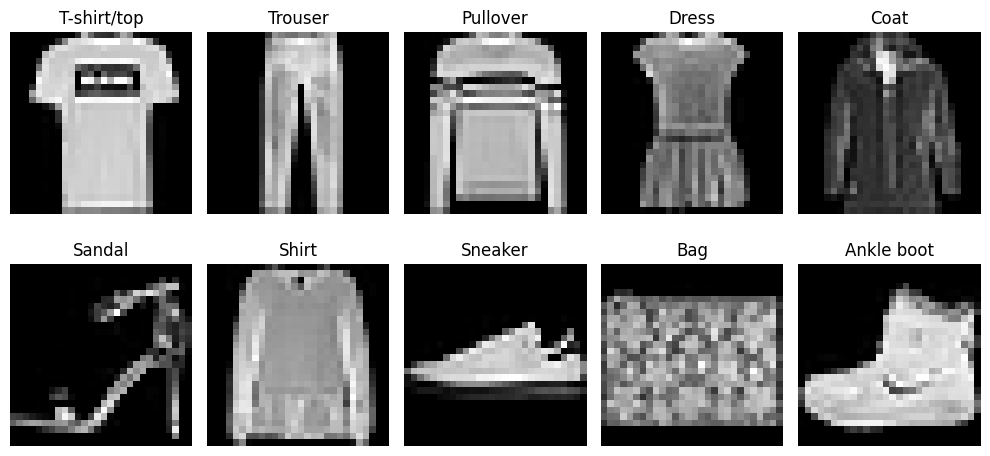

In [ ]:
#Q1
import numpy as np
import matplotlib.pyplot as plt
import wandb
from keras.datasets import fashion_mnist

wandb.init(project="DA6401_A1", name="Q1", mode="online")
wandb_images = []
(xtr,ytr),(xts,yts) = fashion_mnist.load_data()
l = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
f,a = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    img = xtr[ytr==i][0]
    a[i//5,i%5].imshow(img, cmap='gray')
    a[i//5,i%5].set_title(l[i])
    a[i//5,i%5].axis('off')
    wandb_images.append(wandb.Image(img, caption=l[i]))
plt.tight_layout()
plt.show()
wandb.log({"Q1": wandb_images})
wandb.finish()

In [ ]:
#Q3.1
def train_sgd(X, Y, layer_sizes, lr, epochs):
    parameters = initialize_parameters(layer_sizes)
    for epoch in range(epochs):
        for i in range(X.shape[0]):
            x, y = X[i:i+1], Y[i:i+1]
            Y_pred, arr = forward(x, parameters)
            loss_step = compute_loss(Y_pred, y)
            grads = backward(x, y, parameters, arr)
            parameters = update_parameters(parameters, grads, lr)
        loss_epoch = compute_loss(forward(X, parameters)[0], Y)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_epoch:.4f}")
    return parameters

In [ ]:
#Q3.2
def train_momentum(X, Y, layer_sizes, lr, epochs, batch_size, beta=0.9):
    parameters = initialize_parameters(layer_sizes)
    velocities = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    for epoch in range(epochs):
        for i in range(0, X.shape[0], batch_size):
            x, y = X[i:i+batch_size], Y[i:i+batch_size]
            Y_pred, arr = forward(x, parameters)
            grads = backward(x, y, parameters, arr)
            for j in range(len(parameters)):
                W, b = parameters[j]
                dW, db = grads[j+1]
                vW, vb = velocities[j]
                vW = beta * vW - lr * dW
                vb = beta * vb - lr * db
                W += vW
                b += vb
                parameters[j] = (W, b)
                velocities[j] = (vW, vb)
        loss = compute_loss(forward(X, parameters)[0], Y)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
    return parameters

In [ ]:
#Q3.3
def train_nag(X, Y, layer_sizes, lr, epochs, batch_size, beta=0.9):
    parameters = initialize_parameters(layer_sizes)
    velocities = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    for epoch in range(epochs):
        for i in range(0, X.shape[0], batch_size):
            x, y = X[i:i+batch_size], Y[i:i+batch_size]
            lookahead_parameters = []
            for j in range(len(parameters)):
                W, b = parameters[j]
                vW, vb = velocities[j]
                lookahead_parameters.append((W + beta * vW, b + beta * vb))
            Y_pred, arr = forward(x, lookahead_parameters)
            grads = backward(x, y, lookahead_parameters, arr)
            for j in range(len(parameters)):
                W, b = parameters[j]
                dW, db = grads[j+1]
                vW, vb = velocities[j]
                vW = beta * vW - lr * dW
                vb = beta * vb - lr * db
                W += vW
                b += vb
                parameters[j] = (W, b)
                velocities[j] = (vW, vb)
        loss = compute_loss(forward(X, parameters)[0], Y)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
    return parameters

In [ ]:
#Q3.4
def train_rmsprop(X, Y, layer_sizes, lr, epochs, batch_size=1, beta=0.9, epsilon=1e-8):
    parameters = initialize_parameters(layer_sizes)
    cache = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    for epoch in range(epochs):
        for i in range(0, X.shape[0], batch_size):
            x, y = X[i:i+batch_size], Y[i:i+batch_size]
            Y_pred, arr = forward(x, parameters)
            grads = backward(x, y, parameters, arr)
            for j in range(len(parameters)):
                W, b = parameters[j]
                dW, db = grads[j+1]
                sW, sb = cache[j]
                sW = beta * sW + (1 - beta) * (dW ** 2)
                sb = beta * sb + (1 - beta) * (db ** 2)
                W -= lr * dW / (np.sqrt(sW) + epsilon)
                b -= lr * db / (np.sqrt(sb) + epsilon)
                parameters[j] = (W, b)
                cache[j] = (sW, sb)
        loss = compute_loss(forward(X, parameters)[0], Y)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
    return parameters

In [ ]:
#Q3.5
def train_adam(X, Y, layer_sizes, lr, epochs, batch_size, beta1=0.9, beta2=0.999, epsilon=1e-8):
    parameters = initialize_parameters(layer_sizes)
    m_t = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    v_t = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    for epoch in range(epochs):
        for i in range(0, X.shape[0], batch_size):
            x, y = X[i:i+batch_size], Y[i:i+batch_size]
            Y_pred, arr = forward(x, parameters)
            grads = backward(x, y, parameters, arr)
            for j in range(len(parameters)):
                W, b = parameters[j]
                dW, db = grads[j+1]
                mW, mb = m_t[j]
                vW, vb = v_t[j]
                mW = beta1 * mW + (1 - beta1) * dW
                mb = beta1 * mb + (1 - beta1) * db
                vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                vb = beta2 * vb + (1 - beta2) * (db ** 2)
                mW_hat = mW / (1 - beta1 ** (epoch + 1))
                mb_hat = mb / (1 - beta1 ** (epoch + 1))
                vW_hat = vW / (1 - beta2 ** (epoch + 1))
                vb_hat = vb / (1 - beta2 ** (epoch + 1))
                W -= lr * mW_hat / (np.sqrt(vW_hat) + epsilon)
                b -= lr * mb_hat / (np.sqrt(vb_hat) + epsilon)
                parameters[j] = (W, b)
                m_t[j] = (mW, mb)
                v_t[j] = (vW, vb)
        loss = compute_loss(forward(X, parameters)[0], Y)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
    return parameters

In [ ]:
#Q3.6
def train_nadam(X, Y, layer_sizes, lr, epochs, batch_size, beta1=0.9, beta2=0.999, epsilon=1e-8):
    parameters = initialize_parameters(layer_sizes)
    m_t = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    v_t = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    for epoch in range(epochs):
        for i in range(0, X.shape[0], batch_size):
            x, y = X[i:i+batch_size], Y[i:i+batch_size]
            Y_pred, arr = forward(x, parameters)
            grads = backward(x, y, parameters, arr)
            for j in range(len(parameters)):
                W, b = parameters[j]
                dW, db = grads[j+1]
                mW, mb = m_t[j]
                vW, vb = v_t[j]
                mW = beta1 * mW + (1 - beta1) * dW
                mb = beta1 * mb + (1 - beta1) * db
                vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                vb = beta2 * vb + (1 - beta2) * (db ** 2)
                mW_hat = mW / (1 - beta1 ** (epoch + 1))
                mb_hat = mb / (1 - beta1 ** (epoch + 1))
                vW_hat = vW / (1 - beta2 ** (epoch + 1))
                vb_hat = vb / (1 - beta2 ** (epoch + 1))
                mW_nesterov = beta1 * mW_hat + (1 - beta1) * dW
                mb_nesterov = beta1 * mb_hat + (1 - beta1) * db
                W -= lr * mW_nesterov / (np.sqrt(vW_hat) + epsilon)
                b -= lr * mb_nesterov / (np.sqrt(vb_hat) + epsilon)
                parameters[j] = (W, b)
                m_t[j] = (mW, mb)
                v_t[j] = (vW, vb)
        loss = compute_loss(forward(X, parameters)[0], Y)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
    return parameters

In [ ]:
#Q2
import numpy as np
from keras.datasets import fashion_mnist
import random

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def sigmoid_derivative(x):
    return x * (1 - x)

def initialize_parameters(layer_sizes):
    np.random.seed(1)
    parameters = []
    for i in range(len(layer_sizes) - 1):
        W = np.random.uniform(-0.01, 0.01, (layer_sizes[i], layer_sizes[i+1]))
        b = np.zeros((1, layer_sizes[i+1]))
        parameters.append((W, b))
    return parameters

def forward(X, parameters):
    arr = {0: X}
    A = X

    for i, (W, b) in enumerate(parameters[:-1]):
        Z = np.dot(A, W) + b
        A = sigmoid(Z)
        arr[i+1] = A

    W_out, b_out = parameters[-1]
    Z_out = np.dot(A, W_out) + b_out
    A_out = softmax(Z_out)

    arr[len(parameters)] = A_out
    return A_out, arr

def backward(X, Y, parameters, arr):
    m = X.shape[0]
    grads = {}

    A_out = arr[len(parameters)]
    dZ_out = A_out
    dZ_out[np.arange(m), Y] -= 1
    dZ_out /= m

    grads[len(parameters)] = (np.dot(arr[len(parameters)-1].T, dZ_out), np.sum(dZ_out, axis=0, keepdims=True))

    dA = np.dot(dZ_out, parameters[-1][0].T)

    for i in reversed(range(len(parameters) - 1)):
        dZ = dA * sigmoid_derivative(arr[i+1])
        grads[i+1] = (np.dot(arr[i].T, dZ), np.sum(dZ, axis=0, keepdims=True))
        dA = np.dot(dZ, parameters[i][0].T)

    return grads

def update_parameters(parameters, grads, lr):
    for i in range(len(parameters)):
        W, b = parameters[i]
        dW, db = grads[i+1]
        W -= lr * dW
        b -= lr * db
        parameters[i] = (W, b)
    return parameters

def compute_loss(Y_pred, Y_true):
    return -np.mean(np.log(Y_pred[np.arange(Y_true.shape[0]), Y_true] + 1e-9))

def train(X, Y, layer_sizes, lr=0.01, epochs=10, batch_size=64):
    parameters = initialize_parameters(layer_sizes)

    for epoch in range(epochs):
        for i in range(0, X.shape[0], batch_size):
            x, y = X[i:i+batch_size], Y[i:i+batch_size]

            Y_pred, arr = forward(x, parameters)

            grads = backward(x, y, parameters, arr)

            parameters = update_parameters(parameters, grads, lr)

        loss = compute_loss(forward(X, parameters)[0], Y)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

    return parameters

def predict(X, parameters):
    return np.argmax(forward(X, parameters)[0], axis=1)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20, Loss: 2.3062
Epoch 2/20, Loss: 2.3051
Epoch 3/20, Loss: 2.3045
Epoch 4/20, Loss: 2.3042
Epoch 5/20, Loss: 2.3039
Epoch 6/20, Loss: 2.3017
Epoch 7/20, Loss: 2.2397
Epoch 8/20, Loss: 1.6701
Epoch 9/20, Loss: 1.5231
Epoch 10/20, Loss: 1.3482
Epoch 11/20, Loss: 1.1605
Epoch 12/20, Loss: 0.9511
Epoch 13/20, Loss: 0.8413
Epoch 14/20, Loss: 0.7784
Epoch 15/20, Loss: 0.7235
Epoch 16/20, Loss: 0.6776
Epoch 17/20, Loss: 0.6300
Epoch 18/20, Loss: 0.5739
Epoch 19/20, Loss: 0.5261
Epoch 20/20, Loss: 0.4882
Test Accuracy: 81.98%


In [ ]:
sweep_config = {
    "method": "bayes",  # Bayesian optimization
    "metric": {"name": "val_loss", "goal": "minimize"},  # Optimize for lowest validation loss
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "Xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "ReLU"]}
    }
}

In [ ]:
from keras.datasets import fashion_mnist
import numpy as np
import wandb

def initialize_weights(input_size, hidden_sizes, output_size, weight_init):
    np.random.seed(1)
    parameters = []
    layer_sizes = [input_size] + hidden_sizes + [output_size]

    for i in range(len(layer_sizes) - 1):
        if weight_init == "random":
            W = np.random.uniform(-0.01, 0.01, (layer_sizes[i], layer_sizes[i+1]))
        elif weight_init == "Xavier":
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(1 / layer_sizes[i])
        b = np.zeros((1, layer_sizes[i+1]))
        parameters.append((W, b))
    return parameters

def train_wandb():
    wandb.init()
    config = wandb.config

    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    val_split = int(0.9 * X_train.shape[0])
    X_train, X_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    parameters = initialize_weights(784, [config.hidden_size] * config.hidden_layers, 10, config.weight_init)

    optimizer = {
        "sgd": train_sgd,
        "momentum": train_momentum,
        "nesterov": train_nag,
        "rmsprop": train_rmsprop,
        "adam": train_adam,
        "nadam": train_nadam
    }[config.optimizer]

    trained_params = optimizer(X_train, y_train, [784] + [config.hidden_size] * config.hidden_layers + [10],
                               lr=config.learning_rate, epochs=config.epochs, batch_size=config.batch_size)

    y_train_pred = predict(X_train, trained_params)
    train_acc = np.mean(y_train_pred == y_train) * 100
    train_loss = compute_loss(forward(X_train, trained_params)[0], y_train)

    y_val_pred = predict(X_val, trained_params)
    val_acc = np.mean(y_val_pred == y_val) * 100
    val_loss = compute_loss(forward(X_val, trained_params)[0], y_val)

    wandb.log({
        "loss": train_loss,
        "accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "epoch": config.epochs
    })

    return trained_params

sweep_id = wandb.sweep(sweep_config, project="DA6401_A1")
wandb.agent(sweep_id, train_wandb, count=2)

AttributeError: partially initialized module 'wandb' has no attribute 'sdk' (most likely due to a circular import)

AttributeError: partially initialized module 'wandb' has no attribute 'sdk' (most likely due to a circular import)

In [ ]:
import numpy as np
import wandb
import pandas as pd
from keras.datasets import fashion_mnist

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

# Derivatives of activation functions
def sigmoid_derivative(x):
    return x * (1 - x)

def tanh_derivative(x):
    return 1 - np.power(x, 2)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Initialize parameters with different initialization methods
def initialize_parameters(layer_sizes, init_method="random", weight_decay=0):
    np.random.seed(1)
    parameters = []

    for i in range(len(layer_sizes) - 1):
        if init_method == "random":
            W = np.random.uniform(-0.1, 0.1, (layer_sizes[i], layer_sizes[i+1]))
        elif init_method == "xavier":
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / (layer_sizes[i] + layer_sizes[i+1]))

        b = np.zeros((1, layer_sizes[i+1]))
        parameters.append((W, b))

    return parameters

# Forward pass with configurable activation function
def forward(X, parameters, activation="sigmoid"):
    arr = {0: X}
    A = X

    # Get activation function
    act_func = sigmoid
    if activation == "tanh":
        act_func = tanh
    elif activation == "relu":
        act_func = relu

    # Hidden layers
    for i, (W, b) in enumerate(parameters[:-1]):
        Z = np.dot(A, W) + b
        A = act_func(Z)
        arr[i+1] = A

    # Output layer with softmax
    W_out, b_out = parameters[-1]
    Z_out = np.dot(A, W_out) + b_out
    A_out = softmax(Z_out)

    arr[len(parameters)] = A_out
    return A_out, arr

# Backward pass with configurable activation function
def backward(X, Y, parameters, arr, activation="sigmoid", weight_decay=0):
    m = X.shape[0]
    grads = {}

    # Get activation derivative
    act_deriv = sigmoid_derivative
    if activation == "tanh":
        act_deriv = tanh_derivative
    elif activation == "relu":
        act_deriv = relu_derivative

    # Output layer gradient
    A_out = arr[len(parameters)]
    dZ_out = A_out.copy()
    dZ_out[np.arange(m), Y] -= 1
    dZ_out /= m

    # Add L2 regularization
    W_out = parameters[-1][0]
    reg_term = 0
    if weight_decay > 0:
        reg_term = weight_decay * W_out

    grads[len(parameters)] = (np.dot(arr[len(parameters)-1].T, dZ_out) + reg_term,
                              np.sum(dZ_out, axis=0, keepdims=True))

    dA = np.dot(dZ_out, parameters[-1][0].T)

    # Hidden layers gradients
    for i in reversed(range(len(parameters) - 1)):
        # For ReLU, we need to apply derivative to Z, not A
        if activation == "relu":
            # For ReLU, we need to calculate derivative differently
            # Get the pre-activation values
            if i == 0:
                prev_A = arr[i]
            else:
                prev_A = arr[i]

            W, b = parameters[i]
            Z = np.dot(prev_A, W) + b
            dZ = dA * relu_derivative(Z)
        else:
            # For sigmoid and tanh, we can apply derivative to A
            dZ = dA * act_deriv(arr[i+1])

        # Add L2 regularization
        W = parameters[i][0]
        reg_term = 0
        if weight_decay > 0:
            reg_term = weight_decay * W

        grads[i+1] = (np.dot(arr[i].T, dZ) + reg_term,
                     np.sum(dZ, axis=0, keepdims=True))

        dA = np.dot(dZ, parameters[i][0].T)

    return grads

# Compute loss with L2 regularization
def compute_loss(Y_pred, Y_true, parameters=None, weight_decay=0):
    cross_entropy = -np.mean(np.log(Y_pred[np.arange(Y_true.shape[0]), Y_true] + 1e-9))

    # Add L2 regularization term if applicable
    reg_term = 0
    if weight_decay > 0 and parameters is not None:
        for W, _ in parameters:
            reg_term += 0.5 * weight_decay * np.sum(np.square(W))

    return cross_entropy + reg_term

# Updated update_parameters function
def update_parameters(parameters, grads, lr):
    for i in range(len(parameters)):
        W, b = parameters[i]
        dW, db = grads[i+1]
        W = W - lr * dW
        b = b - lr * db
        parameters[i] = (W, b)
    return parameters

# Helper function to perform train/validation split without sklearn
def custom_train_val_split(X, y, val_size=0.1, random_seed=42):
    np.random.seed(random_seed)
    indices = np.random.permutation(X.shape[0])
    val_samples = int(X.shape[0] * val_size)
    val_indices = indices[:val_samples]
    train_indices = indices[val_samples:]

    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

    return X_train, X_val, y_train, y_val

# Training using different optimizers
def train_model(config=None):
    with wandb.init(config=config):
        # Get hyperparameters from wandb config
        config = wandb.config

        # Load and prepare data
        (X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

        # Flatten and normalize the data
        X_train_full = X_train_full.reshape(-1, 28 * 28) / 255.0
        X_test = X_test.reshape(-1, 28 * 28) / 255.0

        # Split off validation set (10% of training data)
        X_train, X_val, y_train, y_val = custom_train_val_split(
            X_train_full, y_train_full, val_size=0.1, random_seed=42
        )

        # Determine layer sizes based on configuration
        input_size = X_train.shape[1]
        output_size = 10  # 10 classes for Fashion MNIST

        # Create hidden layer architecture
        hidden_layers = [config.hidden_size] * config.num_hidden_layers
        layer_sizes = [input_size] + hidden_layers + [output_size]

        print(f"Network architecture: {layer_sizes}")

        # Initialize parameters
        if config.weight_init == "xavier":
            parameters = initialize_parameters(layer_sizes, init_method="xavier")
        else:
            parameters = initialize_parameters(layer_sizes, init_method="random")

        # Choose optimizer based on configuration
        optimizer = config.optimizer
        weight_decay = config.weight_decay
        batch_size = config.batch_size

        # Train the model with the chosen optimizer
        if optimizer == "sgd":
            # Train in mini-batches for SGD
            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    # Forward pass
                    y_pred, cache = forward(X_batch, parameters, activation=config.activation)

                    # Backward pass
                    grads = backward(X_batch, y_batch, parameters, cache,
                                    activation=config.activation, weight_decay=weight_decay)

                    # Update parameters
                    parameters = update_parameters(parameters, grads, config.learning_rate)

                    # Compute batch loss
                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                # Compute epoch loss
                epoch_loss = np.mean(batch_losses)

                # Calculate training and validation accuracy
                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                # Log metrics
                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc,
                    "loss": epoch_loss,        # Additional metric for graph
                    "accuracy": train_acc      # Additional metric for graph
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer == "momentum":
            # Initialize velocities
            velocities = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    # Forward pass
                    y_pred, cache = forward(X_batch, parameters, activation=config.activation)

                    # Backward pass
                    grads = backward(X_batch, y_batch, parameters, cache,
                                    activation=config.activation, weight_decay=weight_decay)

                    # Update with momentum
                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = grads[j+1]
                        vW, vb = velocities[j]

                        # Update velocities
                        vW = beta * vW - config.learning_rate * dW
                        vb = beta * vb - config.learning_rate * db

                        # Update parameters
                        W = W + vW
                        b = b + vb

                        parameters[j] = (W, b)
                        velocities[j] = (vW, vb)

                    # Compute batch loss
                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                # Compute epoch loss and accuracies
                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                # Log metrics
                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc,
                    "loss": epoch_loss,
                    "accuracy": train_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer == "nesterov":
            # Initialize velocities
            velocities = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    # Look ahead parameters
                    lookahead_parameters = []
                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        vW, vb = velocities[j]
                        lookahead_W = W + beta * vW
                        lookahead_b = b + beta * vb
                        lookahead_parameters.append((lookahead_W, lookahead_b))

                    # Forward pass with lookahead parameters
                    y_pred, cache = forward(X_batch, lookahead_parameters, activation=config.activation)

                    # Backward pass with lookahead parameters
                    grads = backward(X_batch, y_batch, lookahead_parameters, cache,
                                    activation=config.activation, weight_decay=weight_decay)

                    # Update with nesterov momentum
                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = grads[j+1]
                        vW, vb = velocities[j]

                        # Update velocities
                        vW = beta * vW - config.learning_rate * dW
                        vb = beta * vb - config.learning_rate * db

                        # Update parameters
                        W = W + vW
                        b = b + vb

                        parameters[j] = (W, b)
                        velocities[j] = (vW, vb)

                    # Compute batch loss (with updated parameters)
                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                # Compute epoch loss and accuracies
                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                # Log metrics
                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc,
                    "loss": epoch_loss,
                    "accuracy": train_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer == "rmsprop":
            # Initialize cache
            cache = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9
            epsilon = 1e-8

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    # Forward pass
                    y_pred, cache_act = forward(X_batch, parameters, activation=config.activation)

                    # Backward pass
                    grads = backward(X_batch, y_batch, parameters, cache_act,
                                    activation=config.activation, weight_decay=weight_decay)

                    # Update with RMSprop
                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = grads[j+1]
                        sW, sb = cache[j]

                        # Update cache
                        sW = beta * sW + (1 - beta) * (dW ** 2)
                        sb = beta * sb + (1 - beta) * (db ** 2)

                        # Update parameters
                        W = W - config.learning_rate * dW / (np.sqrt(sW) + epsilon)
                        b = b - config.learning_rate * db / (np.sqrt(sb) + epsilon)

                        parameters[j] = (W, b)
                        cache[j] = (sW, sb)

                    # Compute batch loss
                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                # Compute epoch loss and accuracies
                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                # Log metrics
                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc,
                    "loss": epoch_loss,
                    "accuracy": train_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer == "adam":
            # Initialize moment estimates
            m = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            v = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 1e-8
            t = 0

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    t += 1  # Update time step
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    # Forward pass
                    y_pred, cache = forward(X_batch, parameters, activation=config.activation)

                    # Backward pass
                    grads = backward(X_batch, y_batch, parameters, cache,
                                    activation=config.activation, weight_decay=weight_decay)

                    # Update with Adam
                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = grads[j+1]
                        mW, mb = m[j]
                        vW, vb = v[j]

                        # Update biased first moment estimate
                        mW = beta1 * mW + (1 - beta1) * dW
                        mb = beta1 * mb + (1 - beta1) * db

                        # Update biased second raw moment estimate
                        vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                        vb = beta2 * vb + (1 - beta2) * (db ** 2)

                        # Compute bias-corrected first moment estimate
                        mW_hat = mW / (1 - beta1**t)
                        mb_hat = mb / (1 - beta1**t)

                        # Compute bias-corrected second raw moment estimate
                        vW_hat = vW / (1 - beta2**t)
                        vb_hat = vb / (1 - beta2**t)

                        # Update parameters
                        W = W - config.learning_rate * mW_hat / (np.sqrt(vW_hat) + epsilon)
                        b = b - config.learning_rate * mb_hat / (np.sqrt(vb_hat) + epsilon)

                        parameters[j] = (W, b)
                        m[j] = (mW, mb)
                        v[j] = (vW, vb)

                    # Compute batch loss
                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                # Compute epoch loss and accuracies
                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                # Log metrics
                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc,
                    "loss": epoch_loss,
                    "accuracy": train_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer == "nadam":
            # Initialize moment estimates
            m = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            v = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 1e-8
            t = 0

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    t += 1  # Update time step
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    # Forward pass
                    y_pred, cache = forward(X_batch, parameters, activation=config.activation)

                    # Backward pass
                    grads = backward(X_batch, y_batch, parameters, cache,
                                    activation=config.activation, weight_decay=weight_decay)

                    # Update with Nadam
                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = grads[j+1]
                        mW, mb = m[j]
                        vW, vb = v[j]

                        # Update biased first moment estimate
                        mW = beta1 * mW + (1 - beta1) * dW
                        mb = beta1 * mb + (1 - beta1) * db

                        # Update biased second raw moment estimate
                        vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                        vb = beta2 * vb + (1 - beta2) * (db ** 2)

                        # Compute bias-corrected first moment estimate
                        mW_hat = mW / (1 - beta1**t)
                        mb_hat = mb / (1 - beta1**t)

                        # Compute bias-corrected second raw moment estimate
                        vW_hat = vW / (1 - beta2**t)
                        vb_hat = vb / (1 - beta2**t)

                        # Compute Nesterov momentum
                        mW_nesterov = beta1 * mW_hat + (1 - beta1) * dW / (1 - beta1**t)
                        mb_nesterov = beta1 * mb_hat + (1 - beta1) * db / (1 - beta1**t)

                        # Update parameters
                        W = W - config.learning_rate * mW_nesterov / (np.sqrt(vW_hat) + epsilon)
                        b = b - config.learning_rate * mb_nesterov / (np.sqrt(vb_hat) + epsilon)

                        parameters[j] = (W, b)
                        m[j] = (mW, mb)
                        v[j] = (vW, vb)

                    # Compute batch loss
                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                # Compute epoch loss and accuracies
                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                # Log metrics
                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc,
                    "loss": epoch_loss,
                    "accuracy": train_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Final evaluation on test set
        test_pred, _ = forward(X_test, parameters, activation=config.activation)
        test_loss = compute_loss(test_pred, y_test, parameters, weight_decay)
        test_acc = np.mean(np.argmax(test_pred, axis=1) == y_test)

        # Log final test metrics
        wandb.log({
            "test_loss": test_loss,
            "test_accuracy": test_acc
        })

        print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

        return parameters

# Setup Hyperparameter Sweep
def setup_wandb_sweep():
    sweep_config = {
        'method': 'bayes',  # Using Bayesian optimization for efficiency
        'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
        'parameters': {
            'epochs': {'values': [5, 10]},
            'num_hidden_layers': {'values': [3, 4, 5]},
            'hidden_size': {'values': [32, 64, 128]},
            'weight_decay': {'values': [0, 0.0005, 0.5]},
            'learning_rate': {'values': [1e-3, 1e-4]},
            'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
            'batch_size': {'values': [16, 32, 64]},
            'weight_init': {'values': ['random', 'xavier']},
            'activation': {'values': ['sigmoid', 'tanh', 'relu']}
        }
    }

    return wandb.sweep(sweep_config, project="DA6401_A1")

# Main function to run the hyperparameter sweep
def main():
    # Initialize wandb
    wandb.login()

    # Setup the sweep
    sweep_id = setup_wandb_sweep()

    # Run the sweep
    wandb.agent(sweep_id, train_model, count=20)  # Limit to 20 runs for efficiency

if __name__ == "__main__":
    main()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: surendarmohan283 (surendarmohan283-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: 2myskbel
Sweep URL: https://wandb.ai/surendarmohan283-indian-institute-of-technology-madras/DA6401_A1/sweeps/2myskbel


wandb: Agent Starting Run: lg3mm3y5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Network architecture: [784, 32, 32, 32, 32, 32, 10]
Epoch 1/5, Train Loss: 1.7701, Val Loss: 1.4246, Val Acc: 0.6238
Epoch 2/5, Train Loss: 1.2433, Val Loss: 1.1211, Val Acc: 0.6767
Epoch 3/5, Train Loss: 1.0201, Val Loss: 0.9603, Val Acc: 0.7083
Epoch 4/5, Train Loss: 0.8934, Val Loss: 0.8595, Val Acc: 0.7323
Epoch 5/5, Train Loss: 0.8128, Val Loss: 0.7936, Val Acc: 0.7553
Final Test Loss: 0.7993, Test Accuracy: 0.7549


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▄▃▂▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▄▅▇█
val_loss,█▅▃▂▁
accuracy,0.75841
epoch,5


wandb: Agent Starting Run: 89zvnkrd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Network architecture: [784, 32, 32, 32, 10]
Epoch 1/5, Train Loss: 5.4286, Val Loss: 2.3261, Val Acc: 0.0917
Epoch 2/5, Train Loss: 2.3062, Val Loss: 2.3028, Val Acc: 0.0917
Epoch 3/5, Train Loss: 2.3027, Val Loss: 2.3028, Val Acc: 0.0917
Epoch 4/5, Train Loss: 2.3027, Val Loss: 2.3029, Val Acc: 0.0917
Epoch 5/5, Train Loss: 2.3027, Val Loss: 2.3029, Val Acc: 0.0917
Final Test Loss: 2.3027, Test Accuracy: 0.1000


accuracy,▁▁▁▁▁
epoch,▁▃▅▆█
loss,█▁▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▁▁
train_loss,█▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,█▁▁▁▁
accuracy,0.10093
epoch,5


wandb: Agent Starting Run: o3ldxqa0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/5, Train Loss: 0.5904, Val Loss: 0.4782, Val Acc: 0.8597
Epoch 2/5, Train Loss: 0.4642, Val Loss: 0.4974, Val Acc: 0.8507
Epoch 3/5, Train Loss: 0.4350, Val Loss: 0.4278, Val Acc: 0.8757
Epoch 4/5, Train Loss: 0.4147, Val Loss: 0.4153, Val Acc: 0.8757
Epoch 5/5, Train Loss: 0.4005, Val Loss: 0.4205, Val Acc: 0.8768
Final Test Loss: 0.4496, Test Accuracy: 0.8721


accuracy,▂▁▆▇█
epoch,▁▃▅▆█
loss,█▃▂▂▁
test_accuracy,▁
test_loss,▁
train_accuracy,▂▁▆▇█
train_loss,█▃▂▂▁
val_accuracy,▃▁███
val_loss,▆█▂▁▁
accuracy,0.89202
epoch,5


wandb: Agent Starting Run: 9wg7h3xx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 64, 64, 64, 10]
Epoch 1/5, Train Loss: 0.8178, Val Loss: 0.4813, Val Acc: 0.8250
Epoch 2/5, Train Loss: 0.4411, Val Loss: 0.4131, Val Acc: 0.8495
Epoch 3/5, Train Loss: 0.3920, Val Loss: 0.3895, Val Acc: 0.8597
Epoch 4/5, Train Loss: 0.3649, Val Loss: 0.3564, Val Acc: 0.8730
Epoch 5/5, Train Loss: 0.3476, Val Loss: 0.3583, Val Acc: 0.8687
Final Test Loss: 0.3967, Test Accuracy: 0.8607


accuracy,▁▄▆██
epoch,▁▃▅▆█
loss,█▂▂▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆██
train_loss,█▂▂▁▁
val_accuracy,▁▅▆█▇
val_loss,█▄▃▁▁
accuracy,0.88137
epoch,5


wandb: Agent Starting Run: c7mn2jbd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Network architecture: [784, 64, 64, 64, 64, 64, 10]
Epoch 1/5, Train Loss: 0.5978, Val Loss: 0.5212, Val Acc: 0.8455
Epoch 2/5, Train Loss: 0.5053, Val Loss: 0.5060, Val Acc: 0.8545
Epoch 3/5, Train Loss: 0.4789, Val Loss: 0.5176, Val Acc: 0.8488
Epoch 4/5, Train Loss: 0.4675, Val Loss: 0.4909, Val Acc: 0.8587
Epoch 5/5, Train Loss: 0.4523, Val Loss: 0.4728, Val Acc: 0.8630
Final Test Loss: 0.4918, Test Accuracy: 0.8588


accuracy,▁▃▂▅█
epoch,▁▃▅▆█
loss,█▄▂▂▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▂▅█
train_loss,█▄▂▂▁
val_accuracy,▁▅▂▆█
val_loss,█▆▇▄▁
accuracy,0.87787
epoch,5


wandb: Agent Starting Run: 9x5lmgoj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Network architecture: [784, 64, 64, 64, 64, 64, 10]
Epoch 1/5, Train Loss: 0.8444, Val Loss: 0.6251, Val Acc: 0.8123
Epoch 2/5, Train Loss: 0.5726, Val Loss: 0.5492, Val Acc: 0.8387
Epoch 3/5, Train Loss: 0.5245, Val Loss: 0.5071, Val Acc: 0.8530
Epoch 4/5, Train Loss: 0.4988, Val Loss: 0.5035, Val Acc: 0.8552
Epoch 5/5, Train Loss: 0.4790, Val Loss: 0.4895, Val Acc: 0.8570
Final Test Loss: 0.5203, Test Accuracy: 0.8495


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▂▁
accuracy,0.86674
epoch,5


wandb: Agent Starting Run: gtbfw9nz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Network architecture: [784, 64, 64, 64, 64, 64, 10]
Epoch 1/5, Train Loss: 32.4823, Val Loss: 7.1682, Val Acc: 0.0983
Epoch 2/5, Train Loss: 3.6885, Val Loss: 2.4259, Val Acc: 0.0917
Epoch 3/5, Train Loss: 2.3284, Val Loss: 2.3029, Val Acc: 0.0917
Epoch 4/5, Train Loss: 2.3027, Val Loss: 2.3028, Val Acc: 0.0917
Epoch 5/5, Train Loss: 2.3026, Val Loss: 2.3028, Val Acc: 0.0917
Final Test Loss: 2.3026, Test Accuracy: 0.1000


accuracy,▁████
epoch,▁▃▅▆█
loss,█▁▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁████
train_loss,█▁▁▁▁
val_accuracy,█▁▁▁▁
val_loss,█▁▁▁▁
accuracy,0.10093
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iv7h5o2n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 64, 64, 64, 10]
Epoch 1/5, Train Loss: 2.1882, Val Loss: 1.8909, Val Acc: 0.3812
Epoch 2/5, Train Loss: 1.5899, Val Loss: 1.3623, Val Acc: 0.6020
Epoch 3/5, Train Loss: 1.2031, Val Loss: 1.0750, Val Acc: 0.6712
Epoch 4/5, Train Loss: 0.9576, Val Loss: 0.8722, Val Acc: 0.7252
Epoch 5/5, Train Loss: 0.7982, Val Loss: 0.7505, Val Acc: 0.7508
Final Test Loss: 0.7605, Test Accuracy: 0.7474


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▆██
val_loss,█▅▃▂▁
accuracy,0.75944
epoch,5


wandb: Agent Starting Run: ypelqcbu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 64, 64, 64, 64, 10]
Epoch 1/10, Train Loss: 0.5352, Val Loss: 0.4064, Val Acc: 0.8490
Epoch 2/10, Train Loss: 0.3964, Val Loss: 0.3680, Val Acc: 0.8702
Epoch 3/10, Train Loss: 0.3578, Val Loss: 0.4016, Val Acc: 0.8513
Epoch 4/10, Train Loss: 0.3351, Val Loss: 0.3360, Val Acc: 0.8808
Epoch 5/10, Train Loss: 0.3168, Val Loss: 0.3599, Val Acc: 0.8682
Epoch 6/10, Train Loss: 0.3052, Val Loss: 0.3551, Val Acc: 0.8708
Epoch 7/10, Train Loss: 0.2885, Val Loss: 0.3423, Val Acc: 0.8753
Epoch 8/10, Train Loss: 0.2793, Val Loss: 0.3485, Val Acc: 0.8732
Epoch 9/10, Train Loss: 0.2719, Val Loss: 0.3526, Val Acc: 0.8725
Epoch 10/10, Train Loss: 0.2625, Val Loss: 0.3261, Val Acc: 0.8815
Final Test Loss: 0.3555, Test Accuracy: 0.8744


accuracy,▁▄▂▅▅▅▆▆▆█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▂▅▅▅▆▆▆█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▆▂█▅▆▇▆▆█
val_loss,█▅█▂▄▄▂▃▃▁
accuracy,0.90983
epoch,10


wandb: Agent Starting Run: 44f8nj8b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.7513, Val Loss: 0.5815, Val Acc: 0.8338
Epoch 2/10, Train Loss: 0.5515, Val Loss: 0.5293, Val Acc: 0.8512
Epoch 3/10, Train Loss: 0.5137, Val Loss: 0.5038, Val Acc: 0.8593
Epoch 4/10, Train Loss: 0.4895, Val Loss: 0.4946, Val Acc: 0.8655
Epoch 5/10, Train Loss: 0.4732, Val Loss: 0.4795, Val Acc: 0.8720
Epoch 6/10, Train Loss: 0.4588, Val Loss: 0.4934, Val Acc: 0.8547
Epoch 7/10, Train Loss: 0.4456, Val Loss: 0.4672, Val Acc: 0.8665
Epoch 8/10, Train Loss: 0.4360, Val Loss: 0.4462, Val Acc: 0.8788
Epoch 9/10, Train Loss: 0.4262, Val Loss: 0.4443, Val Acc: 0.8795
Epoch 10/10, Train Loss: 0.4184, Val Loss: 0.4377, Val Acc: 0.8773
Final Test Loss: 0.4716, Test Accuracy: 0.8681


accuracy,▁▃▄▅▆▄▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▅▆▄▆▇██
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▄▆███
val_loss,█▅▄▄▃▄▂▁▁▁
accuracy,0.89172
epoch,10


wandb: Agent Starting Run: dd23fsko with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Network architecture: [784, 64, 64, 64, 64, 10]
Epoch 1/10, Train Loss: 0.6050, Val Loss: 0.5139, Val Acc: 0.8432
Epoch 2/10, Train Loss: 0.4940, Val Loss: 0.5011, Val Acc: 0.8475
Epoch 3/10, Train Loss: 0.4657, Val Loss: 0.4741, Val Acc: 0.8567
Epoch 4/10, Train Loss: 0.4478, Val Loss: 0.5033, Val Acc: 0.8502
Epoch 5/10, Train Loss: 0.4341, Val Loss: 0.4872, Val Acc: 0.8518
Epoch 6/10, Train Loss: 0.4270, Val Loss: 0.4729, Val Acc: 0.8550
Epoch 7/10, Train Loss: 0.4168, Val Loss: 0.4155, Val Acc: 0.8752
Epoch 8/10, Train Loss: 0.4132, Val Loss: 0.4939, Val Acc: 0.8453
Epoch 9/10, Train Loss: 0.4099, Val Loss: 0.4754, Val Acc: 0.8572
Epoch 10/10, Train Loss: 0.4047, Val Loss: 0.4435, Val Acc: 0.8690
Final Test Loss: 0.4686, Test Accuracy: 0.8576


accuracy,▁▂▄▃▃▄█▃▄▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▄▃▃▄█▃▄▇
train_loss,█▄▃▃▂▂▁▁▁▁
val_accuracy,▁▂▄▃▃▄█▁▄▇
val_loss,█▇▅▇▆▅▁▇▅▃
accuracy,0.88459
epoch,10


wandb: Agent Starting Run: fs2xdbms with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 1.0790, Val Loss: 0.6334, Val Acc: 0.7743
Epoch 2/10, Train Loss: 0.5596, Val Loss: 0.5075, Val Acc: 0.8177
Epoch 3/10, Train Loss: 0.4875, Val Loss: 0.4722, Val Acc: 0.8320
Epoch 4/10, Train Loss: 0.4520, Val Loss: 0.4501, Val Acc: 0.8385
Epoch 5/10, Train Loss: 0.4248, Val Loss: 0.4217, Val Acc: 0.8498
Epoch 6/10, Train Loss: 0.4053, Val Loss: 0.4070, Val Acc: 0.8573
Epoch 7/10, Train Loss: 0.3889, Val Loss: 0.3907, Val Acc: 0.8640
Epoch 8/10, Train Loss: 0.3759, Val Loss: 0.3831, Val Acc: 0.8653
Epoch 9/10, Train Loss: 0.3626, Val Loss: 0.3780, Val Acc: 0.8627
Epoch 10/10, Train Loss: 0.3523, Val Loss: 0.3736, Val Acc: 0.8645
Final Test Loss: 0.3944, Test Accuracy: 0.8601


accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
accuracy,0.87865
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vobjnpr7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.6564, Val Loss: 0.4720, Val Acc: 0.8262
Epoch 2/10, Train Loss: 0.4454, Val Loss: 0.4163, Val Acc: 0.8490
Epoch 3/10, Train Loss: 0.4061, Val Loss: 0.3945, Val Acc: 0.8572
Epoch 4/10, Train Loss: 0.3835, Val Loss: 0.3821, Val Acc: 0.8608
Epoch 5/10, Train Loss: 0.3658, Val Loss: 0.3683, Val Acc: 0.8660
Epoch 6/10, Train Loss: 0.3529, Val Loss: 0.3612, Val Acc: 0.8695
Epoch 7/10, Train Loss: 0.3407, Val Loss: 0.3481, Val Acc: 0.8742
Epoch 8/10, Train Loss: 0.3319, Val Loss: 0.3438, Val Acc: 0.8768
Epoch 9/10, Train Loss: 0.3221, Val Loss: 0.3423, Val Acc: 0.8738
Epoch 10/10, Train Loss: 0.3139, Val Loss: 0.3455, Val Acc: 0.8732
Final Test Loss: 0.3757, Test Accuracy: 0.8613


accuracy,▁▄▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇███▇
val_loss,█▅▄▃▂▂▁▁▁▁
accuracy,0.88628
epoch,10


wandb: Agent Starting Run: 5sj93rde with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.6564, Val Loss: 0.4720, Val Acc: 0.8262
Epoch 2/10, Train Loss: 0.4454, Val Loss: 0.4163, Val Acc: 0.8490
Epoch 3/10, Train Loss: 0.4061, Val Loss: 0.3945, Val Acc: 0.8572
Epoch 4/10, Train Loss: 0.3835, Val Loss: 0.3821, Val Acc: 0.8608
Epoch 5/10, Train Loss: 0.3658, Val Loss: 0.3683, Val Acc: 0.8660
Epoch 6/10, Train Loss: 0.3529, Val Loss: 0.3612, Val Acc: 0.8695
Epoch 7/10, Train Loss: 0.3407, Val Loss: 0.3481, Val Acc: 0.8742
Epoch 8/10, Train Loss: 0.3319, Val Loss: 0.3438, Val Acc: 0.8768
Epoch 9/10, Train Loss: 0.3221, Val Loss: 0.3423, Val Acc: 0.8738
Epoch 10/10, Train Loss: 0.3139, Val Loss: 0.3455, Val Acc: 0.8732
Final Test Loss: 0.3757, Test Accuracy: 0.8613


accuracy,▁▄▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇███▇
val_loss,█▅▄▃▂▂▁▁▁▁
accuracy,0.88628
epoch,10


wandb: Agent Starting Run: kvozntox with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.6861, Val Loss: 0.5633, Val Acc: 0.8408
Epoch 2/10, Train Loss: 0.5286, Val Loss: 0.5380, Val Acc: 0.8557
Epoch 3/10, Train Loss: 0.4922, Val Loss: 0.4764, Val Acc: 0.8628
Epoch 4/10, Train Loss: 0.4727, Val Loss: 0.5665, Val Acc: 0.8413
Epoch 5/10, Train Loss: 0.4599, Val Loss: 0.4677, Val Acc: 0.8695
Epoch 6/10, Train Loss: 0.4509, Val Loss: 0.4831, Val Acc: 0.8638
Epoch 7/10, Train Loss: 0.4477, Val Loss: 0.4623, Val Acc: 0.8708
Epoch 8/10, Train Loss: 0.4439, Val Loss: 0.5121, Val Acc: 0.8485
Epoch 9/10, Train Loss: 0.4376, Val Loss: 0.4643, Val Acc: 0.8668
Epoch 10/10, Train Loss: 0.4338, Val Loss: 0.4550, Val Acc: 0.8727
Final Test Loss: 0.4792, Test Accuracy: 0.8647


accuracy,▁▃▆▁▇▆▇▄██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▁▁▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▆▁▇▆▇▄██
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▄▆▁▇▆█▃▇█
val_loss,█▆▂█▂▃▁▅▂▁
accuracy,0.88474
epoch,10


wandb: Agent Starting Run: y1e8xfon with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.5980, Val Loss: 0.5045, Val Acc: 0.8563
Epoch 2/10, Train Loss: 0.4787, Val Loss: 0.4948, Val Acc: 0.8535
Epoch 3/10, Train Loss: 0.4443, Val Loss: 0.4888, Val Acc: 0.8528
Epoch 4/10, Train Loss: 0.4246, Val Loss: 0.4912, Val Acc: 0.8498
Epoch 5/10, Train Loss: 0.4072, Val Loss: 0.4361, Val Acc: 0.8717
Epoch 6/10, Train Loss: 0.3972, Val Loss: 0.4152, Val Acc: 0.8825
Epoch 7/10, Train Loss: 0.3885, Val Loss: 0.4122, Val Acc: 0.8792
Epoch 8/10, Train Loss: 0.3816, Val Loss: 0.4268, Val Acc: 0.8738
Epoch 9/10, Train Loss: 0.3745, Val Loss: 0.4016, Val Acc: 0.8862
Epoch 10/10, Train Loss: 0.3712, Val Loss: 0.4120, Val Acc: 0.8783
Final Test Loss: 0.4437, Test Accuracy: 0.8646


accuracy,▁▁▂▂▅▇█▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▂▂▅▇█▇█▇
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▂▂▂▁▅▇▇▆█▆
val_loss,█▇▇▇▃▂▂▃▁▂
accuracy,0.89467
epoch,10


wandb: Agent Starting Run: 1a4qzimx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.5136, Val Loss: 0.4028, Val Acc: 0.8488
Epoch 2/10, Train Loss: 0.4107, Val Loss: 0.3867, Val Acc: 0.8553
Epoch 3/10, Train Loss: 0.3799, Val Loss: 0.3716, Val Acc: 0.8675
Epoch 4/10, Train Loss: 0.3622, Val Loss: 0.3666, Val Acc: 0.8657
Epoch 5/10, Train Loss: 0.3474, Val Loss: 0.3961, Val Acc: 0.8622
Epoch 6/10, Train Loss: 0.3388, Val Loss: 0.3588, Val Acc: 0.8700
Epoch 7/10, Train Loss: 0.3307, Val Loss: 0.3614, Val Acc: 0.8700
Epoch 8/10, Train Loss: 0.3232, Val Loss: 0.3644, Val Acc: 0.8695
Epoch 9/10, Train Loss: 0.3159, Val Loss: 0.3605, Val Acc: 0.8698
Epoch 10/10, Train Loss: 0.3143, Val Loss: 0.3465, Val Acc: 0.8725
Final Test Loss: 0.3694, Test Accuracy: 0.8683


accuracy,▁▃▅▅▄▆▆▇▆█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▅▅▄▆▆▇▆█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▇▆▅▇▇▇▇█
val_loss,█▆▄▃▇▃▃▃▃▁
accuracy,0.89541
epoch,10


wandb: Agent Starting Run: jmzanisd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.4649, Val Loss: 0.4065, Val Acc: 0.8532
Epoch 2/10, Train Loss: 0.3671, Val Loss: 0.4063, Val Acc: 0.8487
Epoch 3/10, Train Loss: 0.3364, Val Loss: 0.3574, Val Acc: 0.8712
Epoch 4/10, Train Loss: 0.3160, Val Loss: 0.3773, Val Acc: 0.8602
Epoch 5/10, Train Loss: 0.2969, Val Loss: 0.3310, Val Acc: 0.8827
Epoch 6/10, Train Loss: 0.2873, Val Loss: 0.3260, Val Acc: 0.8825
Epoch 7/10, Train Loss: 0.2741, Val Loss: 0.3252, Val Acc: 0.8842
Epoch 8/10, Train Loss: 0.2650, Val Loss: 0.3156, Val Acc: 0.8883
Epoch 9/10, Train Loss: 0.2565, Val Loss: 0.3213, Val Acc: 0.8848
Epoch 10/10, Train Loss: 0.2497, Val Loss: 0.3159, Val Acc: 0.8903
Final Test Loss: 0.3386, Test Accuracy: 0.8800


accuracy,▁▁▄▃▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▄▃▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▂▁▅▃▇▇▇█▇█
val_loss,██▄▆▂▂▂▁▁▁
accuracy,0.91702
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ql3blgl7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.6736, Val Loss: 0.5363, Val Acc: 0.8407
Epoch 2/10, Train Loss: 0.5050, Val Loss: 0.5390, Val Acc: 0.8377
Epoch 3/10, Train Loss: 0.4674, Val Loss: 0.4658, Val Acc: 0.8620
Epoch 4/10, Train Loss: 0.4442, Val Loss: 0.4687, Val Acc: 0.8593
Epoch 5/10, Train Loss: 0.4252, Val Loss: 0.4425, Val Acc: 0.8725
Epoch 6/10, Train Loss: 0.4160, Val Loss: 0.4468, Val Acc: 0.8653
Epoch 7/10, Train Loss: 0.4039, Val Loss: 0.4250, Val Acc: 0.8728
Epoch 8/10, Train Loss: 0.3980, Val Loss: 0.4225, Val Acc: 0.8753
Epoch 9/10, Train Loss: 0.3893, Val Loss: 0.4302, Val Acc: 0.8745
Epoch 10/10, Train Loss: 0.3840, Val Loss: 0.4145, Val Acc: 0.8787
Final Test Loss: 0.4461, Test Accuracy: 0.8736


accuracy,▁▁▅▅▆▆▇█▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▅▅▆▆▇█▇█
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▂▁▅▅▇▆▇▇▇█
val_loss,██▄▄▃▃▂▁▂▁
accuracy,0.89491
epoch,10


wandb: Agent Starting Run: dm0c17qd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.6415, Val Loss: 0.5463, Val Acc: 0.8487
Epoch 2/10, Train Loss: 0.5270, Val Loss: 0.5683, Val Acc: 0.8367
Epoch 3/10, Train Loss: 0.4934, Val Loss: 0.5098, Val Acc: 0.8492
Epoch 4/10, Train Loss: 0.4722, Val Loss: 0.4805, Val Acc: 0.8567
Epoch 5/10, Train Loss: 0.4566, Val Loss: 0.4529, Val Acc: 0.8767
Epoch 6/10, Train Loss: 0.4451, Val Loss: 0.4421, Val Acc: 0.8730
Epoch 7/10, Train Loss: 0.4390, Val Loss: 0.4412, Val Acc: 0.8795
Epoch 8/10, Train Loss: 0.4341, Val Loss: 0.4471, Val Acc: 0.8732
Epoch 9/10, Train Loss: 0.4268, Val Loss: 0.4467, Val Acc: 0.8735
Epoch 10/10, Train Loss: 0.4222, Val Loss: 0.4276, Val Acc: 0.8752
Final Test Loss: 0.4547, Test Accuracy: 0.8668


accuracy,▂▁▄▅▇▇▇█▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
train_accuracy,▂▁▄▅▇▇▇█▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▃▁▃▄█▇█▇▇▇
val_loss,▇█▅▄▂▂▂▂▂▁
accuracy,0.89343
epoch,10


In [ ]:
import numpy as np
import wandb
import pandas as pd
from keras.datasets import fashion_mnist

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh_derivative(x):
    return 1 - np.power(x, 2)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def initialize_parameters(layer_sizes, init_method="random", weight_decay=0):
    np.random.seed(1)
    parameters = []

    for i in range(len(layer_sizes) - 1):
        if init_method == "random":
            W = np.random.uniform(-0.1, 0.1, (layer_sizes[i], layer_sizes[i+1]))
        elif init_method == "xavier":
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / (layer_sizes[i] + layer_sizes[i+1]))

        b = np.zeros((1, layer_sizes[i+1]))
        parameters.append((W, b))

    return parameters

def forward(X, parameters, activation="sigmoid"):
    a = {0: X}
    A = X

    act_func = sigmoid
    if activation == "tanh":
        act_func = tanh
    elif activation == "relu":
        act_func = relu

    for i, (W, b) in enumerate(parameters[:-1]):
        Z = np.dot(A, W) + b
        A = act_func(Z)
        a[i+1] = A

    W_out, b_out = parameters[-1]
    Z_out = np.dot(A, W_out) + b_out
    A_out = softmax(Z_out)

    a[len(parameters)] = A_out
    return A_out, a

def backward(X, Y, parameters, a, activation="sigmoid", weight_decay=0):
    m = X.shape[0]
    gradients = {}

    act_deriv = sigmoid_derivative
    if activation == "tanh":
        act_deriv = tanh_derivative
    elif activation == "relu":
        act_deriv = relu_derivative

    A_out = a[len(parameters)]
    dZ_out = A_out.copy()
    dZ_out[np.arange(m), Y] -= 1
    dZ_out /= m

    W_out = parameters[-1][0]
    reg_term = 0
    if weight_decay > 0:
        reg_term = weight_decay * W_out

    gradients[len(parameters)] = (np.dot(a[len(parameters)-1].T, dZ_out) + reg_term,
                              np.sum(dZ_out, axis=0, keepdims=True))

    dA = np.dot(dZ_out, parameters[-1][0].T)

    for i in reversed(range(len(parameters) - 1)):
        if activation == "relu":
            if i == 0:
                prev_A = a[i]
            else:
                prev_A = a[i]

            W, b = parameters[i]
            Z = np.dot(prev_A, W) + b
            dZ = dA * relu_derivative(Z)
        else:
            dZ = dA * act_deriv(a[i+1])

        W = parameters[i][0]
        reg_term = 0
        if weight_decay > 0:
            reg_term = weight_decay * W

        gradients[i+1] = (np.dot(a[i].T, dZ) + reg_term,
                     np.sum(dZ, axis=0, keepdims=True))

        dA = np.dot(dZ, parameters[i][0].T)

    return gradients

def compute_loss(Y_pred, Y_true, parameters=None, weight_decay=0):
    cross_entropy = -np.mean(np.log(Y_pred[np.arange(Y_true.shape[0]), Y_true] + 1e-9))

    reg_term = 0
    if weight_decay > 0 and parameters is not None:
        for W, _ in parameters:
            reg_term += 0.5 * weight_decay * np.sum(np.square(W))

    return cross_entropy + reg_term

def update_parameters(parameters, gradients, lr):
    for i in range(len(parameters)):
        W, b = parameters[i]
        dW, db = gradients[i+1]
        W = W - lr * dW
        b = b - lr * db
        parameters[i] = (W, b)
    return parameters

def create_train_val_split(X, y, val_ratio=0.1, random_seed=42):
    np.random.seed(random_seed)
    indices = np.random.permutation(len(X))
    val_size = int(len(X) * val_ratio)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_val = X[val_indices]
    y_val = y[val_indices]

    return X_train, X_val, y_train, y_val

def train_model():
    with wandb.init() as run:
        config = wandb.config

        run.name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_opt_{config.optimizer}_ac_{config.activation}_wd_{config.weight_decay}"

        (X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

        X_train_full = X_train_full.reshape(-1, 28 * 28) / 255.0
        X_test = X_test.reshape(-1, 28 * 28) / 255.0

        X_train, X_val, y_train, y_val = create_train_val_split(
            X_train_full, y_train_full, val_ratio=0.1, random_seed=42
        )

        input_size = X_train.shape[1]
        output_size = 10

        hidden_layers = [config.hidden_size] * config.num_hidden_layers
        layer_sizes = [input_size] + hidden_layers + [output_size]

        print(f"Network architecture: {layer_sizes}")

        if config.weight_init == "xavier":
            parameters = initialize_parameters(layer_sizes, init_method="xavier")
        else:
            parameters = initialize_parameters(layer_sizes, init_method="random")

        optimizer_type = config.optimizer
        weight_decay = config.weight_decay
        batch_size = config.batch_size

        if optimizer_type == "sgd":
            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, weight_decay=weight_decay)

                    parameters = update_parameters(parameters, gradients, config.learning_rate)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "momentum":
            momentum_values = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        vW, vb = momentum_values[j]

                        vW = beta * vW - config.learning_rate * dW
                        vb = beta * vb - config.learning_rate * db

                        W = W + vW
                        b = b + vb

                        parameters[j] = (W, b)
                        momentum_values[j] = (vW, vb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "nesterov":
            momentum_values = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    lookahead_parameters = []
                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        vW, vb = momentum_values[j]
                        lookahead_W = W + beta * vW
                        lookahead_b = b + beta * vb
                        lookahead_parameters.append((lookahead_W, lookahead_b))

                    y_pred, layer_activations = forward(X_batch, lookahead_parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, lookahead_parameters, layer_activations,
                                    activation=config.activation, weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        vW, vb = momentum_values[j]

                        vW = beta * vW - config.learning_rate * dW
                        vb = beta * vb - config.learning_rate * db

                        W = W + vW
                        b = b + vb

                        parameters[j] = (W, b)
                        momentum_values[j] = (vW, vb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "rmsprop":
            squared_grads = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9
            epsilon = 1e-8

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        sW, sb = squared_grads[j]

                        sW = beta * sW + (1 - beta) * (dW ** 2)
                        sb = beta * sb + (1 - beta) * (db ** 2)

                        W = W - config.learning_rate * dW / (np.sqrt(sW) + epsilon)
                        b = b - config.learning_rate * db / (np.sqrt(sb) + epsilon)

                        parameters[j] = (W, b)
                        squared_grads[j] = (sW, sb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "adam":
            first_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            second_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 1e-8
            t = 0

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    t += 1
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        mW, mb = first_moment[j]
                        vW, vb = second_moment[j]

                        mW = beta1 * mW + (1 - beta1) * dW
                        mb = beta1 * mb + (1 - beta1) * db

                        vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                        vb = beta2 * vb + (1 - beta2) * (db ** 2)

                        mW_hat = mW / (1 - beta1**t)
                        mb_hat = mb / (1 - beta1**t)

                        vW_hat = vW / (1 - beta2**t)
                        vb_hat = vb / (1 - beta2**t)

                        W = W - config.learning_rate * mW_hat / (np.sqrt(vW_hat) + epsilon)
                        b = b - config.learning_rate * mb_hat / (np.sqrt(vb_hat) + epsilon)

                        parameters[j] = (W, b)
                        first_moment[j] = (mW, mb)
                        second_moment[j] = (vW, vb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "nadam":
            first_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            second_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 1e-8
            t = 0

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    t += 1
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        mW, mb = first_moment[j]
                        vW, vb = second_moment[j]

                        mW = beta1 * mW + (1 - beta1) * dW
                        mb = beta1 * mb + (1 - beta1) * db

                        vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                        vb = beta2 * vb + (1 - beta2) * (db ** 2)

                        mW_hat = mW / (1 - beta1**t)
                        mb_hat = mb / (1 - beta1**t)

                        vW_hat = vW / (1 - beta2**t)
                        vb_hat = vb / (1 - beta2**t)

                        mW_nesterov = beta1 * mW_hat + (1 - beta1) * dW / (1 - beta1**t)
                        mb_nesterov = beta1 * mb_hat + (1 - beta1) * db / (1 - beta1**t)

                        W = W - config.learning_rate * mW_nesterov / (np.sqrt(vW_hat) + epsilon)
                        b = b - config.learning_rate * mb_nesterov / (np.sqrt(vb_hat) + epsilon)

                        parameters[j] = (W, b)
                        first_moment[j] = (mW, mb)
                        second_moment[j] = (vW, vb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        test_pred, _ = forward(X_test, parameters, activation=config.activation)
        test_loss = compute_loss(test_pred, y_test, parameters, weight_decay)
        test_acc = np.mean(np.argmax(test_pred, axis=1) == y_test)

        wandb.log({
            "test_loss": test_loss,
            "test_accuracy": test_acc
        })

        print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

        return parameters

def setup_wandb_sweep():
    sweep_config = {
        'method': 'bayes',
        'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
        'parameters': {
            'epochs': {'values': [5, 10]},
            'num_hidden_layers': {'values': [3, 4, 5]},
            'hidden_size': {'values': [32, 64, 128]},
            'weight_decay': {'values': [0, 0.0005, 0.5]},
            'learning_rate': {'values': [1e-3, 1e-4]},
            'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
            'batch_size': {'values': [16, 32, 64]},
            'weight_init': {'values': ['random', 'xavier']},
            'activation': {'values': ['sigmoid', 'tanh', 'relu']}
        }
    }

    return wandb.sweep(sweep_config, project="DA6401_A1")

wandb.login()
sweep_id = setup_wandb_sweep()
wandb.agent(sweep_id, train_model, count=20)

Create sweep with ID: ozdk80lj
Sweep URL: https://wandb.ai/surendarmohan283-indian-institute-of-technology-madras/DA6401_A1/sweeps/ozdk80lj


wandb: Agent Starting Run: ml4fygbz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Network architecture: [784, 128, 128, 128, 128, 128, 10]
Epoch 1/5, Train Loss: 1.3315, Val Loss: 0.8240, Val Acc: 0.6403
Epoch 2/5, Train Loss: 0.7207, Val Loss: 0.6636, Val Acc: 0.7317
Epoch 3/5, Train Loss: 0.5721, Val Loss: 0.5461, Val Acc: 0.8018
Epoch 4/5, Train Loss: 0.4838, Val Loss: 0.5151, Val Acc: 0.7970
Epoch 5/5, Train Loss: 0.4374, Val Loss: 0.4553, Val Acc: 0.8250
Final Test Loss: 0.4782, Test Accuracy: 0.8184


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▄▇▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,0.8184
test_loss,0.47817
train_accuracy,0.84154


wandb: Agent Starting Run: gj9r36wx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 32, 32, 32, 32, 10]
Epoch 1/5, Train Loss: 1.8154, Val Loss: 1.4498, Val Acc: 0.6203
Epoch 2/5, Train Loss: 1.2438, Val Loss: 1.1001, Val Acc: 0.6990
Epoch 3/5, Train Loss: 0.9869, Val Loss: 0.9114, Val Acc: 0.7245
Epoch 4/5, Train Loss: 0.8409, Val Loss: 0.7992, Val Acc: 0.7383
Epoch 5/5, Train Loss: 0.7525, Val Loss: 0.7284, Val Acc: 0.7538
Final Test Loss: 0.7400, Test Accuracy: 0.7514


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
epoch,5
test_accuracy,0.7514
test_loss,0.74002
train_accuracy,0.76191


wandb: Agent Starting Run: i3c2mo92 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.9413, Val Loss: 0.5481, Val Acc: 0.7878
Epoch 2/10, Train Loss: 0.4894, Val Loss: 0.4462, Val Acc: 0.8367
Epoch 3/10, Train Loss: 0.4282, Val Loss: 0.3937, Val Acc: 0.8587
Epoch 4/10, Train Loss: 0.3959, Val Loss: 0.3711, Val Acc: 0.8682
Epoch 5/10, Train Loss: 0.3717, Val Loss: 0.3598, Val Acc: 0.8725
Epoch 6/10, Train Loss: 0.3510, Val Loss: 0.3743, Val Acc: 0.8627
Epoch 7/10, Train Loss: 0.3373, Val Loss: 0.3400, Val Acc: 0.8788
Epoch 8/10, Train Loss: 0.3248, Val Loss: 0.3410, Val Acc: 0.8808
Epoch 9/10, Train Loss: 0.3153, Val Loss: 0.3908, Val Acc: 0.8612
Epoch 10/10, Train Loss: 0.3055, Val Loss: 0.3853, Val Acc: 0.8607
Final Test Loss: 0.4238, Test Accuracy: 0.8494


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇▇▇██▇▇
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇██▇▆
val_loss,█▅▃▂▂▂▁▁▃▃
epoch,10
test_accuracy,0.8494
test_loss,0.42382
train_accuracy,0.87541


wandb: Agent Starting Run: qithm3l7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.8718, Val Loss: 0.5233, Val Acc: 0.8127
Epoch 2/10, Train Loss: 0.4712, Val Loss: 0.4326, Val Acc: 0.8405
Epoch 3/10, Train Loss: 0.4186, Val Loss: 0.4031, Val Acc: 0.8527
Epoch 4/10, Train Loss: 0.3921, Val Loss: 0.3873, Val Acc: 0.8587
Epoch 5/10, Train Loss: 0.3738, Val Loss: 0.3763, Val Acc: 0.8615
Epoch 6/10, Train Loss: 0.3603, Val Loss: 0.3576, Val Acc: 0.8682
Epoch 7/10, Train Loss: 0.3487, Val Loss: 0.3520, Val Acc: 0.8705
Epoch 8/10, Train Loss: 0.3384, Val Loss: 0.3462, Val Acc: 0.8755
Epoch 9/10, Train Loss: 0.3297, Val Loss: 0.3416, Val Acc: 0.8787
Epoch 10/10, Train Loss: 0.3224, Val Loss: 0.3414, Val Acc: 0.8775
Final Test Loss: 0.3725, Test Accuracy: 0.8657


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.8657
test_loss,0.3725
train_accuracy,0.88735


wandb: Agent Starting Run: 47lbgjln with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.8917, Val Loss: 0.5705, Val Acc: 0.7950
Epoch 2/10, Train Loss: 0.5111, Val Loss: 0.4891, Val Acc: 0.8277
Epoch 3/10, Train Loss: 0.4546, Val Loss: 0.4512, Val Acc: 0.8382
Epoch 4/10, Train Loss: 0.4254, Val Loss: 0.4190, Val Acc: 0.8473
Epoch 5/10, Train Loss: 0.4046, Val Loss: 0.4070, Val Acc: 0.8540
Epoch 6/10, Train Loss: 0.3883, Val Loss: 0.3880, Val Acc: 0.8593
Epoch 7/10, Train Loss: 0.3750, Val Loss: 0.3878, Val Acc: 0.8610
Epoch 8/10, Train Loss: 0.3631, Val Loss: 0.3759, Val Acc: 0.8642
Epoch 9/10, Train Loss: 0.3529, Val Loss: 0.3621, Val Acc: 0.8687
Epoch 10/10, Train Loss: 0.3443, Val Loss: 0.3679, Val Acc: 0.8668
Final Test Loss: 0.3940, Test Accuracy: 0.8582


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,0.8582
test_loss,0.39398
train_accuracy,0.87824


wandb: Agent Starting Run: spg4rq0w with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Network architecture: [784, 64, 64, 64, 10]
Epoch 1/10, Train Loss: 19.1106, Val Loss: 4.8820, Val Acc: 0.1045
Epoch 2/10, Train Loss: 2.9604, Val Loss: 2.3356, Val Acc: 0.0917
Epoch 3/10, Train Loss: 2.3083, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 4/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 5/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 6/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 7/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 8/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 9/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Epoch 10/10, Train Loss: 2.3026, Val Loss: 2.3027, Val Acc: 0.0917
Final Test Loss: 2.3026, Test Accuracy: 0.1000


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁█████████
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
test_loss,2.30259
train_accuracy,0.10093


wandb: Agent Starting Run: 2ceahs4c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 1.8845, Val Loss: 1.3743, Val Acc: 0.4193
Epoch 2/10, Train Loss: 1.1928, Val Loss: 1.0942, Val Acc: 0.5835
Epoch 3/10, Train Loss: 0.9985, Val Loss: 0.8979, Val Acc: 0.6883
Epoch 4/10, Train Loss: 0.8015, Val Loss: 0.7371, Val Acc: 0.7468
Epoch 5/10, Train Loss: 0.6880, Val Loss: 0.6588, Val Acc: 0.7633
Epoch 6/10, Train Loss: 0.6277, Val Loss: 0.6107, Val Acc: 0.7723
Epoch 7/10, Train Loss: 0.5861, Val Loss: 0.5753, Val Acc: 0.7830
Epoch 8/10, Train Loss: 0.5557, Val Loss: 0.5497, Val Acc: 0.7902
Epoch 9/10, Train Loss: 0.5321, Val Loss: 0.5258, Val Acc: 0.7958
Epoch 10/10, Train Loss: 0.5117, Val Loss: 0.5107, Val Acc: 0.7978
Final Test Loss: 0.5318, Test Accuracy: 0.8016


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8016
test_loss,0.53183
train_accuracy,0.81143


wandb: Agent Starting Run: yea4rz7b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 2.2253, Val Loss: 2.1426, Val Acc: 0.5182
Epoch 2/10, Train Loss: 2.0100, Val Loss: 1.8498, Val Acc: 0.5292
Epoch 3/10, Train Loss: 1.6711, Val Loss: 1.5221, Val Acc: 0.5332
Epoch 4/10, Train Loss: 1.4080, Val Loss: 1.3226, Val Acc: 0.5585
Epoch 5/10, Train Loss: 1.2475, Val Loss: 1.1951, Val Acc: 0.5740
Epoch 6/10, Train Loss: 1.1385, Val Loss: 1.1035, Val Acc: 0.5910
Epoch 7/10, Train Loss: 1.0569, Val Loss: 1.0323, Val Acc: 0.6097
Epoch 8/10, Train Loss: 0.9921, Val Loss: 0.9750, Val Acc: 0.6247
Epoch 9/10, Train Loss: 0.9388, Val Loss: 0.9261, Val Acc: 0.6408
Epoch 10/10, Train Loss: 0.8937, Val Loss: 0.8849, Val Acc: 0.6525
Final Test Loss: 0.8922, Test Accuracy: 0.6543


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▃▄▅▆▆▇█
train_loss,█▇▅▄▃▂▂▂▁▁
val_accuracy,▁▂▂▃▄▅▆▇▇█
val_loss,█▆▅▃▃▂▂▂▁▁
epoch,10
test_accuracy,0.6543
test_loss,0.89216
train_accuracy,0.66304


wandb: Agent Starting Run: lq9aaal7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 1.8845, Val Loss: 1.3743, Val Acc: 0.4193
Epoch 2/10, Train Loss: 1.1928, Val Loss: 1.0942, Val Acc: 0.5835
Epoch 3/10, Train Loss: 0.9985, Val Loss: 0.8979, Val Acc: 0.6883
Epoch 4/10, Train Loss: 0.8015, Val Loss: 0.7371, Val Acc: 0.7468
Epoch 5/10, Train Loss: 0.6880, Val Loss: 0.6588, Val Acc: 0.7633
Epoch 6/10, Train Loss: 0.6277, Val Loss: 0.6107, Val Acc: 0.7723
Epoch 7/10, Train Loss: 0.5861, Val Loss: 0.5753, Val Acc: 0.7830
Epoch 8/10, Train Loss: 0.5557, Val Loss: 0.5497, Val Acc: 0.7902
Epoch 9/10, Train Loss: 0.5321, Val Loss: 0.5258, Val Acc: 0.7958
Epoch 10/10, Train Loss: 0.5117, Val Loss: 0.5107, Val Acc: 0.7978
Final Test Loss: 0.5318, Test Accuracy: 0.8016


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8016
test_loss,0.53183
train_accuracy,0.81143


wandb: Agent Starting Run: mbw96b8e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 1.9354, Val Loss: 1.5912, Val Acc: 0.3928
Epoch 2/10, Train Loss: 1.3826, Val Loss: 1.2535, Val Acc: 0.5453
Epoch 3/10, Train Loss: 1.1665, Val Loss: 1.0872, Val Acc: 0.6418
Epoch 4/10, Train Loss: 0.9669, Val Loss: 0.8480, Val Acc: 0.6987
Epoch 5/10, Train Loss: 0.7532, Val Loss: 0.6963, Val Acc: 0.7363
Epoch 6/10, Train Loss: 0.6510, Val Loss: 0.6216, Val Acc: 0.7620
Epoch 7/10, Train Loss: 0.5944, Val Loss: 0.5752, Val Acc: 0.7798
Epoch 8/10, Train Loss: 0.5538, Val Loss: 0.5374, Val Acc: 0.7943
Epoch 9/10, Train Loss: 0.5215, Val Loss: 0.5098, Val Acc: 0.8123
Epoch 10/10, Train Loss: 0.4962, Val Loss: 0.4873, Val Acc: 0.8213
Final Test Loss: 0.5134, Test Accuracy: 0.8194


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▆▅▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8194
test_loss,0.51337
train_accuracy,0.82974


wandb: Agent Starting Run: e5feq22r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 1.9593, Val Loss: 1.6074, Val Acc: 0.3980
Epoch 2/10, Train Loss: 1.3926, Val Loss: 1.2557, Val Acc: 0.5403
Epoch 3/10, Train Loss: 1.1676, Val Loss: 1.0881, Val Acc: 0.6307
Epoch 4/10, Train Loss: 0.9930, Val Loss: 0.8950, Val Acc: 0.6800
Epoch 5/10, Train Loss: 0.8007, Val Loss: 0.7362, Val Acc: 0.7242
Epoch 6/10, Train Loss: 0.6918, Val Loss: 0.6657, Val Acc: 0.7422
Epoch 7/10, Train Loss: 0.6364, Val Loss: 0.6166, Val Acc: 0.7610
Epoch 8/10, Train Loss: 0.5952, Val Loss: 0.5780, Val Acc: 0.7757
Epoch 9/10, Train Loss: 0.5608, Val Loss: 0.5506, Val Acc: 0.7850
Epoch 10/10, Train Loss: 0.5333, Val Loss: 0.5220, Val Acc: 0.8008
Final Test Loss: 0.5434, Test Accuracy: 0.8007


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▆▅▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8007
test_loss,0.54338
train_accuracy,0.80967


wandb: Agent Starting Run: w6mi4j6s with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.7470, Val Loss: 0.4919, Val Acc: 0.8257
Epoch 2/10, Train Loss: 0.4491, Val Loss: 0.4296, Val Acc: 0.8445
Epoch 3/10, Train Loss: 0.4064, Val Loss: 0.4153, Val Acc: 0.8492
Epoch 4/10, Train Loss: 0.3811, Val Loss: 0.3775, Val Acc: 0.8613
Epoch 5/10, Train Loss: 0.3623, Val Loss: 0.3822, Val Acc: 0.8630
Epoch 6/10, Train Loss: 0.3480, Val Loss: 0.3618, Val Acc: 0.8687
Epoch 7/10, Train Loss: 0.3338, Val Loss: 0.3576, Val Acc: 0.8742
Epoch 8/10, Train Loss: 0.3235, Val Loss: 0.3572, Val Acc: 0.8730
Epoch 9/10, Train Loss: 0.3145, Val Loss: 0.3401, Val Acc: 0.8790
Epoch 10/10, Train Loss: 0.3036, Val Loss: 0.3416, Val Acc: 0.8790
Final Test Loss: 0.3721, Test Accuracy: 0.8670


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▄▆▆▇▇▇██
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,0.867
test_loss,0.37207
train_accuracy,0.89359


wandb: Agent Starting Run: py9bu8o0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.7616, Val Loss: 0.5032, Val Acc: 0.8228
Epoch 2/10, Train Loss: 0.4539, Val Loss: 0.4295, Val Acc: 0.8465
Epoch 3/10, Train Loss: 0.4100, Val Loss: 0.4127, Val Acc: 0.8503
Epoch 4/10, Train Loss: 0.3846, Val Loss: 0.3907, Val Acc: 0.8582
Epoch 5/10, Train Loss: 0.3661, Val Loss: 0.4018, Val Acc: 0.8573
Epoch 6/10, Train Loss: 0.3505, Val Loss: 0.3620, Val Acc: 0.8717
Epoch 7/10, Train Loss: 0.3355, Val Loss: 0.3543, Val Acc: 0.8763
Epoch 8/10, Train Loss: 0.3254, Val Loss: 0.3565, Val Acc: 0.8752
Epoch 9/10, Train Loss: 0.3167, Val Loss: 0.3356, Val Acc: 0.8830
Epoch 10/10, Train Loss: 0.3038, Val Loss: 0.3447, Val Acc: 0.8780
Final Test Loss: 0.3713, Test Accuracy: 0.8668


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▄▅▅▇▇▇██
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▄▅▅▇▇▇█▇
val_loss,█▅▄▃▄▂▂▂▁▁
epoch,10
test_accuracy,0.8668
test_loss,0.37127
train_accuracy,0.89078


wandb: Agent Starting Run: weaj15hm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.4971, Val Loss: 0.4220, Val Acc: 0.8438
Epoch 2/10, Train Loss: 0.3636, Val Loss: 0.3494, Val Acc: 0.8698
Epoch 3/10, Train Loss: 0.3274, Val Loss: 0.3524, Val Acc: 0.8703
Epoch 4/10, Train Loss: 0.3051, Val Loss: 0.3412, Val Acc: 0.8798
Epoch 5/10, Train Loss: 0.2877, Val Loss: 0.3510, Val Acc: 0.8740
Epoch 6/10, Train Loss: 0.2751, Val Loss: 0.3266, Val Acc: 0.8845
Epoch 7/10, Train Loss: 0.2606, Val Loss: 0.3282, Val Acc: 0.8823
Epoch 8/10, Train Loss: 0.2507, Val Loss: 0.3142, Val Acc: 0.8890
Epoch 9/10, Train Loss: 0.2410, Val Loss: 0.3201, Val Acc: 0.8908
Epoch 10/10, Train Loss: 0.2321, Val Loss: 0.3351, Val Acc: 0.8798
Final Test Loss: 0.3463, Test Accuracy: 0.8773


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▄▄▃▂▂▂▁▁▁
val_accuracy,▁▅▅▆▅▇▇██▆
val_loss,█▃▃▃▃▂▂▁▁▂
epoch,10
test_accuracy,0.8773
test_loss,0.34634
train_accuracy,0.91448


wandb: Agent Starting Run: hyfywpde with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.7568, Val Loss: 0.5021, Val Acc: 0.8285
Epoch 2/10, Train Loss: 0.4557, Val Loss: 0.4356, Val Acc: 0.8442
Epoch 3/10, Train Loss: 0.4108, Val Loss: 0.4039, Val Acc: 0.8580
Epoch 4/10, Train Loss: 0.3850, Val Loss: 0.3914, Val Acc: 0.8628
Epoch 5/10, Train Loss: 0.3669, Val Loss: 0.3713, Val Acc: 0.8682
Epoch 6/10, Train Loss: 0.3520, Val Loss: 0.3681, Val Acc: 0.8652
Epoch 7/10, Train Loss: 0.3387, Val Loss: 0.3552, Val Acc: 0.8727
Epoch 8/10, Train Loss: 0.3273, Val Loss: 0.3443, Val Acc: 0.8775
Epoch 9/10, Train Loss: 0.3182, Val Loss: 0.3461, Val Acc: 0.8798
Epoch 10/10, Train Loss: 0.3097, Val Loss: 0.3369, Val Acc: 0.8828
Final Test Loss: 0.3610, Test Accuracy: 0.8727


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▅▆▆▇▇▇█
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▅▆▆▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8727
test_loss,0.36096
train_accuracy,0.89507


wandb: Agent Starting Run: umfquh1t with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.4971, Val Loss: 0.4220, Val Acc: 0.8438
Epoch 2/10, Train Loss: 0.3636, Val Loss: 0.3494, Val Acc: 0.8698
Epoch 3/10, Train Loss: 0.3274, Val Loss: 0.3524, Val Acc: 0.8703
Epoch 4/10, Train Loss: 0.3051, Val Loss: 0.3412, Val Acc: 0.8798
Epoch 5/10, Train Loss: 0.2877, Val Loss: 0.3510, Val Acc: 0.8740
Epoch 6/10, Train Loss: 0.2751, Val Loss: 0.3266, Val Acc: 0.8845
Epoch 7/10, Train Loss: 0.2606, Val Loss: 0.3282, Val Acc: 0.8823
Epoch 8/10, Train Loss: 0.2507, Val Loss: 0.3142, Val Acc: 0.8890
Epoch 9/10, Train Loss: 0.2410, Val Loss: 0.3201, Val Acc: 0.8908
Epoch 10/10, Train Loss: 0.2321, Val Loss: 0.3351, Val Acc: 0.8798
Final Test Loss: 0.3463, Test Accuracy: 0.8773


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▄▄▃▂▂▂▁▁▁
val_accuracy,▁▅▅▆▅▇▇██▆
val_loss,█▃▃▃▃▂▂▁▁▂
epoch,10
test_accuracy,0.8773
test_loss,0.34634
train_accuracy,0.91448


wandb: Agent Starting Run: ia3obkdr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.6009, Val Loss: 0.4435, Val Acc: 0.8408
Epoch 2/10, Train Loss: 0.4158, Val Loss: 0.3964, Val Acc: 0.8527
Epoch 3/10, Train Loss: 0.3796, Val Loss: 0.3916, Val Acc: 0.8578
Epoch 4/10, Train Loss: 0.3577, Val Loss: 0.3555, Val Acc: 0.8657
Epoch 5/10, Train Loss: 0.3411, Val Loss: 0.3714, Val Acc: 0.8633
Epoch 6/10, Train Loss: 0.3279, Val Loss: 0.3413, Val Acc: 0.8745
Epoch 7/10, Train Loss: 0.3152, Val Loss: 0.3367, Val Acc: 0.8797
Epoch 8/10, Train Loss: 0.3062, Val Loss: 0.3360, Val Acc: 0.8787
Epoch 9/10, Train Loss: 0.2965, Val Loss: 0.3351, Val Acc: 0.8775
Epoch 10/10, Train Loss: 0.2877, Val Loss: 0.3178, Val Acc: 0.8837
Final Test Loss: 0.3502, Test Accuracy: 0.8749


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▃▅▅▆▇▇▇█
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▅▇▇▇▇█
val_loss,█▅▅▃▄▂▂▂▂▁
epoch,10
test_accuracy,0.8749
test_loss,0.35022
train_accuracy,0.90026


wandb: Agent Starting Run: reoy4szk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 0.4873, Val Loss: 0.3994, Val Acc: 0.8515
Epoch 2/10, Train Loss: 0.3773, Val Loss: 0.3903, Val Acc: 0.8555
Epoch 3/10, Train Loss: 0.3470, Val Loss: 0.3697, Val Acc: 0.8630
Epoch 4/10, Train Loss: 0.3233, Val Loss: 0.3662, Val Acc: 0.8643
Epoch 5/10, Train Loss: 0.3053, Val Loss: 0.3435, Val Acc: 0.8738
Epoch 6/10, Train Loss: 0.2945, Val Loss: 0.3273, Val Acc: 0.8830
Epoch 7/10, Train Loss: 0.2835, Val Loss: 0.3379, Val Acc: 0.8790
Epoch 8/10, Train Loss: 0.2767, Val Loss: 0.3301, Val Acc: 0.8807
Epoch 9/10, Train Loss: 0.2641, Val Loss: 0.3375, Val Acc: 0.8758
Epoch 10/10, Train Loss: 0.2580, Val Loss: 0.3246, Val Acc: 0.8823
Final Test Loss: 0.3504, Test Accuracy: 0.8749


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▃▄▅▇▇▇▇█
train_loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▂▄▄▆█▇▇▆█
val_loss,█▇▅▅▃▁▂▂▂▁
epoch,10
test_accuracy,0.8749
test_loss,0.35042
train_accuracy,0.91239


wandb: Agent Starting Run: 74wddfaw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/5, Train Loss: 0.6009, Val Loss: 0.4435, Val Acc: 0.8408
Epoch 2/5, Train Loss: 0.4158, Val Loss: 0.3964, Val Acc: 0.8527
Epoch 3/5, Train Loss: 0.3796, Val Loss: 0.3916, Val Acc: 0.8578
Epoch 4/5, Train Loss: 0.3577, Val Loss: 0.3555, Val Acc: 0.8657
Epoch 5/5, Train Loss: 0.3411, Val Loss: 0.3714, Val Acc: 0.8633
Final Test Loss: 0.4017, Test Accuracy: 0.8539


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▅█▇
train_loss,█▃▂▁▁
val_accuracy,▁▄▆█▇
val_loss,█▄▄▁▂
epoch,5
test_accuracy,0.8539
test_loss,0.40174
train_accuracy,0.87398


wandb: Agent Starting Run: 16r1hoha with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Network architecture: [784, 128, 128, 128, 128, 10]
Epoch 1/10, Train Loss: 1.4510, Val Loss: 1.0453, Val Acc: 0.5960
Epoch 2/10, Train Loss: 0.8534, Val Loss: 0.7210, Val Acc: 0.7455
Epoch 3/10, Train Loss: 0.6495, Val Loss: 0.6133, Val Acc: 0.7682
Epoch 4/10, Train Loss: 0.5667, Val Loss: 0.5439, Val Acc: 0.7908
Epoch 5/10, Train Loss: 0.5217, Val Loss: 0.5205, Val Acc: 0.7970
Epoch 6/10, Train Loss: 0.4913, Val Loss: 0.4833, Val Acc: 0.8200
Epoch 7/10, Train Loss: 0.4645, Val Loss: 0.4563, Val Acc: 0.8378
Epoch 8/10, Train Loss: 0.4413, Val Loss: 0.4383, Val Acc: 0.8410
Epoch 9/10, Train Loss: 0.4221, Val Loss: 0.4227, Val Acc: 0.8508
Epoch 10/10, Train Loss: 0.4058, Val Loss: 0.4071, Val Acc: 0.8540
Final Test Loss: 0.4402, Test Accuracy: 0.8463


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▆▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▆▇████
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
test_accuracy,0.8463
test_loss,0.44015
train_accuracy,0.86143


Network architecture: [784, 128, 128, 128, 128, 10]
Training with Nadam optimizer...
Epoch 1/3, Training Accuracy (subset): 0.8090
Epoch 3/3, Training Accuracy (subset): 0.8880

Test Accuracy: 0.8318


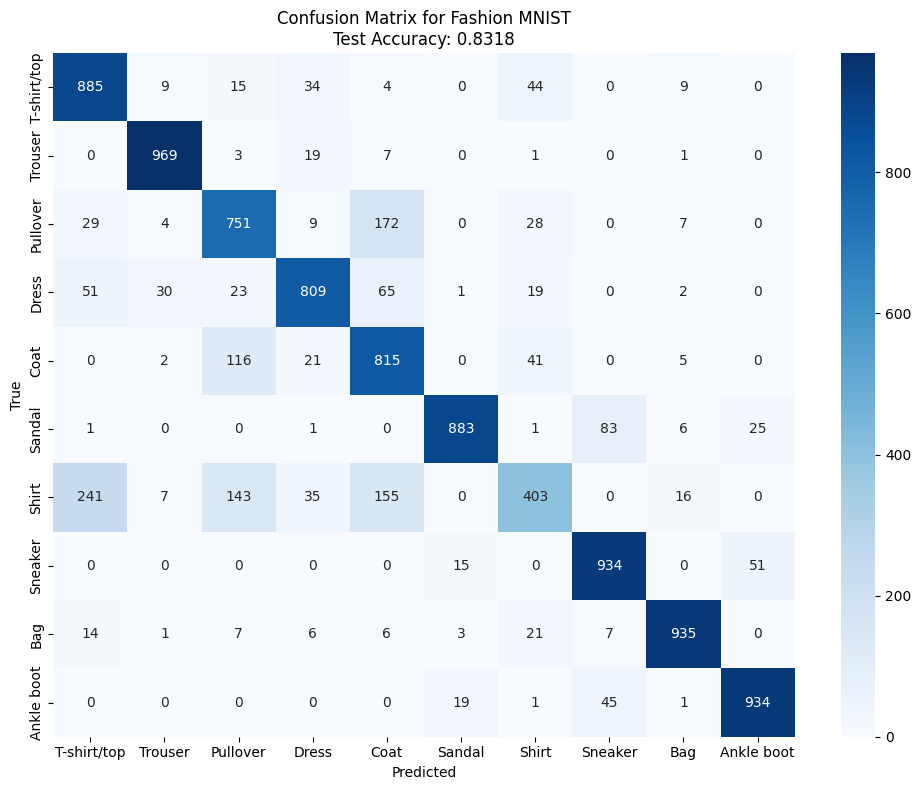


Per-Class Accuracy:
T-shirt/top: 0.8850
Trouser: 0.9690
Pullover: 0.7510
Dress: 0.8090
Coat: 0.8150
Sandal: 0.8830
Shirt: 0.4030
Sneaker: 0.9340
Bag: 0.9350
Ankle boot: 0.9340


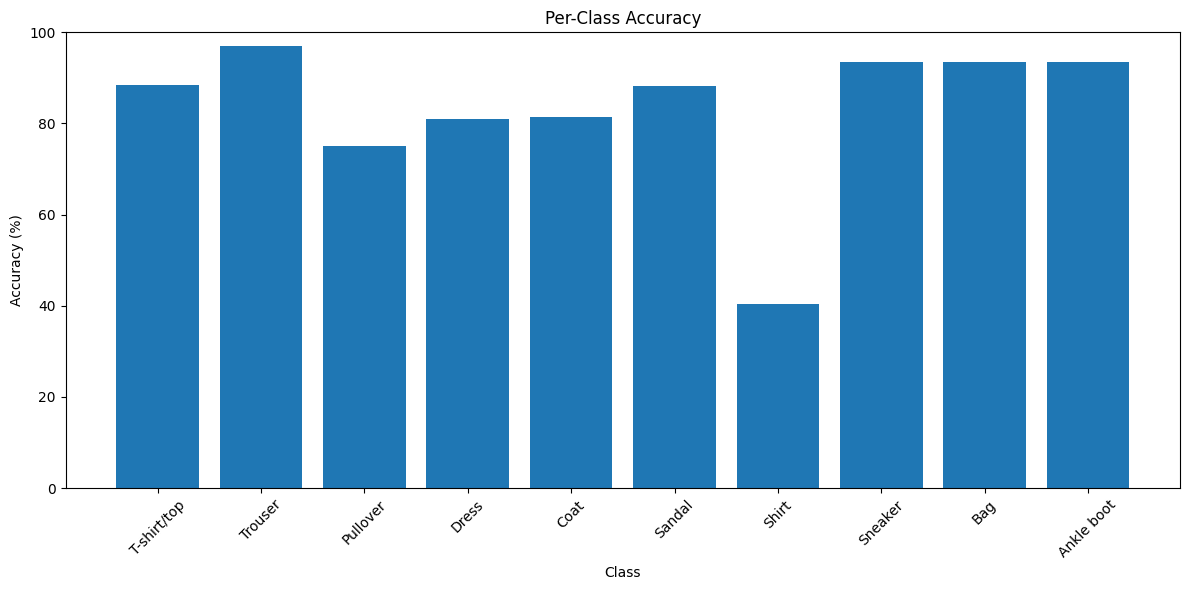


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.72      0.89      0.80      1000
     Trouser       0.95      0.97      0.96      1000
    Pullover       0.71      0.75      0.73      1000
       Dress       0.87      0.81      0.84      1000
        Coat       0.67      0.81      0.73      1000
      Sandal       0.96      0.88      0.92      1000
       Shirt       0.72      0.40      0.52      1000
     Sneaker       0.87      0.93      0.90      1000
         Bag       0.95      0.94      0.94      1000
  Ankle boot       0.92      0.93      0.93      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



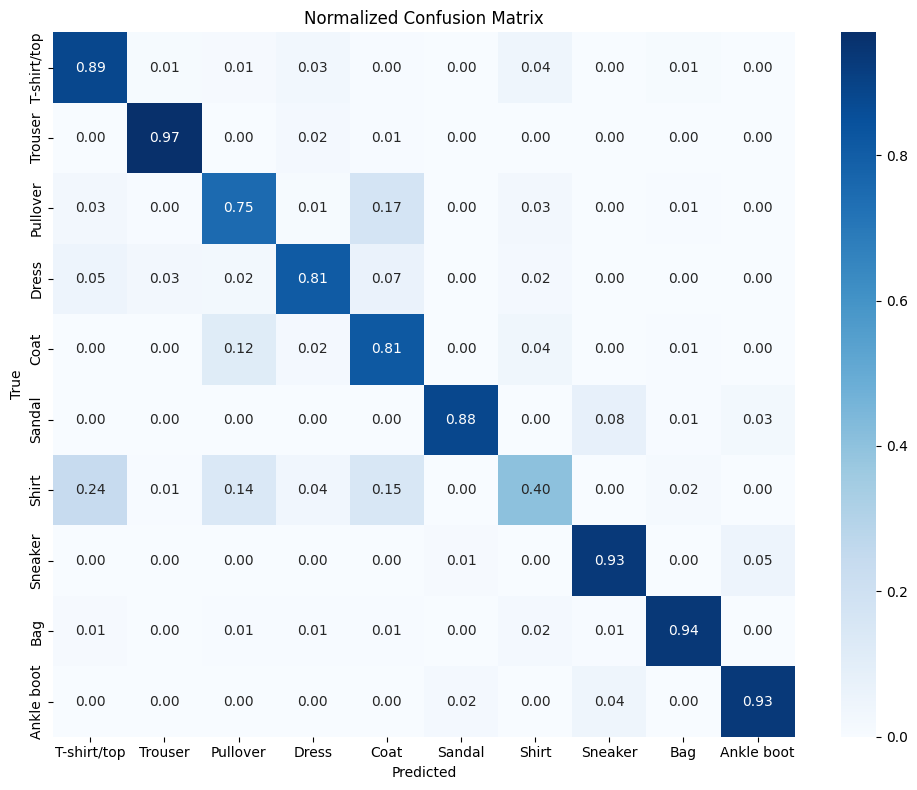

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix

# Import the necessary functions from your code
def tanh(x):
    return np.tanh(x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def forward(X, parameters, activation="tanh"):
    a = {0: X}
    A = X

    act_func = tanh  # Using tanh as specified in your best model

    for i, (W, b) in enumerate(parameters[:-1]):
        Z = np.dot(A, W) + b
        A = act_func(Z)
        a[i+1] = A

    W_out, b_out = parameters[-1]
    Z_out = np.dot(A, W_out) + b_out
    A_out = softmax(Z_out)

    a[len(parameters)] = A_out
    return A_out, a

# Initialize parameters with Xavier initialization as specified
def initialize_parameters(layer_sizes, init_method="xavier"):
    parameters = []

    for i in range(len(layer_sizes) - 1):
        if init_method == "xavier":
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / (layer_sizes[i] + layer_sizes[i+1]))
        else:
            W = np.random.uniform(-0.1, 0.1, (layer_sizes[i], layer_sizes[i+1]))

        b = np.zeros((1, layer_sizes[i+1]))
        parameters.append((W, b))

    return parameters

# Load the test data
(_, _), (X_test, y_test) = fashion_mnist.load_data()
X_test = X_test.reshape(-1, 28 * 28) / 255.0

# Define the model architecture using your best performing model hyperparameters
# activation: "tanh"
# batch_size: 32
# epochs: 10
# hidden_size: 128
# learning_rate: 0.001
# num_hidden_layers: 4
# optimizer: "nadam"
# weight_decay: 0
# weight_init: "xavier"

input_size = 784  # 28x28 pixels
hidden_size = 128  # From your best model
num_hidden_layers = 4  # From your best model
output_size = 10  # 10 classes in Fashion MNIST

# Define the layer sizes
layer_sizes = [input_size] + [hidden_size] * num_hidden_layers + [output_size]
print(f"Network architecture: {layer_sizes}")

# Initialize the parameters with Xavier initialization
parameters = initialize_parameters(layer_sizes, init_method="xavier")

# In a real scenario, you would load the saved model parameters
# For this example, we'll train a simplified version of the model

# Function to train model with nadam optimizer
def train_nadam(X_train, y_train, parameters, epochs=10, batch_size=32, learning_rate=0.001):
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    t = 0

    first_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
    second_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}

    print("Training with Nadam optimizer...")
    for epoch in range(epochs):
        indices = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        batch_losses = []

        for i in range(0, X_train.shape[0], batch_size):
            t += 1
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            # Forward pass
            y_pred, layer_activations = forward(X_batch, parameters, activation="tanh")

            # Backward pass (simplified for this example)
            dZ = y_pred.copy()
            dZ[np.arange(len(y_batch)), y_batch] -= 1
            dZ /= len(y_batch)

            # Update parameters with Nadam optimizer
            for j in range(len(parameters) - 1, -1, -1):
                W, b = parameters[j]
                A_prev = layer_activations[j]

                dW = np.dot(A_prev.T, dZ)
                db = np.sum(dZ, axis=0, keepdims=True)

                mW, mb = first_moment[j]
                vW, vb = second_moment[j]

                mW = beta1 * mW + (1 - beta1) * dW
                mb = beta1 * mb + (1 - beta1) * db

                vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                vb = beta2 * vb + (1 - beta2) * (db ** 2)

                mW_hat = mW / (1 - beta1**t)
                mb_hat = mb / (1 - beta1**t)

                vW_hat = vW / (1 - beta2**t)
                vb_hat = vb / (1 - beta2**t)

                mW_nesterov = beta1 * mW_hat + (1 - beta1) * dW / (1 - beta1**t)
                mb_nesterov = beta1 * mb_hat + (1 - beta1) * db / (1 - beta1**t)

                W = W - learning_rate * mW_nesterov / (np.sqrt(vW_hat) + epsilon)
                b = b - learning_rate * mb_nesterov / (np.sqrt(vb_hat) + epsilon)

                parameters[j] = (W, b)
                first_moment[j] = (mW, mb)
                second_moment[j] = (vW, vb)

                if j > 0:
                    dZ = np.dot(dZ, W.T) * (1 - layer_activations[j]**2)  # derivative of tanh

        if epoch % 2 == 0:
            # Evaluate on a small subset for quick progress tracking
            eval_size = min(1000, X_train.shape[0])
            eval_pred, _ = forward(X_train[:eval_size], parameters, activation="tanh")
            eval_acc = np.mean(np.argmax(eval_pred, axis=1) == y_train[:eval_size])
            print(f"Epoch {epoch+1}/{epochs}, Training Accuracy (subset): {eval_acc:.4f}")

    return parameters

# Load training data for simplified training
(X_train, y_train), _ = fashion_mnist.load_data()
X_train = X_train.reshape(-1, 28 * 28) / 255.0

# Use a small subset for quick demonstration
X_train_subset = X_train[:5000]
y_train_subset = y_train[:5000]

# Train the model (in a real scenario, you would load saved parameters)
trained_parameters = train_nadam(
    X_train_subset,
    y_train_subset,
    parameters,
    epochs=3,  # Reduced for demonstration
    batch_size=32,
    learning_rate=0.001
)

# Get predictions on the test set
y_pred_probs, _ = forward(X_test, trained_parameters, activation="tanh")
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define Fashion MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Fashion MNIST\nTest Accuracy: {accuracy:.4f}')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Additional analysis: Calculate per-class accuracy
class_accuracy = np.zeros(10)
for i in range(10):
    class_indices = (y_test == i)
    class_accuracy[i] = np.mean(y_pred[class_indices] == i)

# Print per-class accuracy report
print("\nPer-Class Accuracy:")
for i, name in enumerate(class_names):
    print(f"{name}: {class_accuracy[i]:.4f}")

# Create a bar chart for per-class accuracy
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_accuracy * 100)
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('per_class_accuracy.png')
plt.show()

# Calculate additional metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Create a normalized confusion matrix (showing percentages)
plt.figure(figsize=(10, 8))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.savefig('normalized_confusion_matrix.png')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.datasets import fashion_mnist
import os
from datetime import datetime

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh_derivative(x):
    return 1 - np.power(x, 2)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def initialize_parameters(layer_sizes, init_method="random", weight_decay=0):
    np.random.seed(1)
    parameters = []

    for i in range(len(layer_sizes) - 1):
        if init_method == "random":
            W = np.random.uniform(-0.1, 0.1, (layer_sizes[i], layer_sizes[i+1]))
        elif init_method == "xavier":
            W = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / (layer_sizes[i] + layer_sizes[i+1]))

        b = np.zeros((1, layer_sizes[i+1]))
        parameters.append((W, b))

    return parameters

def forward(X, parameters, activation="sigmoid"):
    a = {0: X}
    A = X

    act_func = sigmoid
    if activation == "tanh":
        act_func = tanh
    elif activation == "relu":
        act_func = relu

    for i, (W, b) in enumerate(parameters[:-1]):
        Z = np.dot(A, W) + b
        A = act_func(Z)
        a[i+1] = A

    W_out, b_out = parameters[-1]
    Z_out = np.dot(A, W_out) + b_out
    A_out = softmax(Z_out)

    a[len(parameters)] = A_out
    return A_out, a

def backward_with_squared_error(X, Y, parameters, a, activation="sigmoid", weight_decay=0):
    m = X.shape[0]
    gradients = {}

    act_deriv = sigmoid_derivative
    if activation == "tanh":
        act_deriv = tanh_derivative
    elif activation == "relu":
        act_deriv = relu_derivative

    # Convert Y to one-hot encoding
    Y_one_hot = np.zeros((m, a[len(parameters)].shape[1]))
    Y_one_hot[np.arange(m), Y] = 1

    # For squared error, the derivative is different from cross-entropy
    A_out = a[len(parameters)]
    dZ_out = 2 * (A_out - Y_one_hot) / m

    W_out = parameters[-1][0]
    reg_term = 0
    if weight_decay > 0:
        reg_term = weight_decay * W_out

    gradients[len(parameters)] = (np.dot(a[len(parameters)-1].T, dZ_out) + reg_term,
                              np.sum(dZ_out, axis=0, keepdims=True))

    dA = np.dot(dZ_out, parameters[-1][0].T)

    # Rest of the function remains the same as your original backward function
    # ...

    return gradients

def backward(X, Y, parameters, a, activation="sigmoid", weight_decay=0):
    m = X.shape[0]
    gradients = {}

    act_deriv = sigmoid_derivative
    if activation == "tanh":
        act_deriv = tanh_derivative
    elif activation == "relu":
        act_deriv = relu_derivative

    A_out = a[len(parameters)]
    dZ_out = A_out.copy()
    dZ_out[np.arange(m), Y] -= 1
    dZ_out /= m

    W_out = parameters[-1][0]
    reg_term = 0
    if weight_decay > 0:
        reg_term = weight_decay * W_out

    gradients[len(parameters)] = (np.dot(a[len(parameters)-1].T, dZ_out) + reg_term,
                              np.sum(dZ_out, axis=0, keepdims=True))

    dA = np.dot(dZ_out, parameters[-1][0].T)

    for i in reversed(range(len(parameters) - 1)):
        if activation == "relu":
            if i == 0:
                prev_A = a[i]
            else:
                prev_A = a[i]

            W, b = parameters[i]
            Z = np.dot(prev_A, W) + b
            dZ = dA * relu_derivative(Z)
        else:
            dZ = dA * act_deriv(a[i+1])

        W = parameters[i][0]
        reg_term = 0
        if weight_decay > 0:
            reg_term = weight_decay * W

        gradients[i+1] = (np.dot(a[i].T, dZ) + reg_term,
                     np.sum(dZ, axis=0, keepdims=True))

        dA = np.dot(dZ, parameters[i][0].T)

    return gradients

def compute_loss(Y_pred, Y_true, parameters=None, weight_decay=0):
    cross_entropy = -np.mean(np.log(Y_pred[np.arange(Y_true.shape[0]), Y_true] + 1e-9))

    reg_term = 0
    if weight_decay > 0 and parameters is not None:
        for W, _ in parameters:
            reg_term += 0.5 * weight_decay * np.sum(np.square(W))

    return cross_entropy + reg_term

# Add this to your existing code
def squared_error_loss(Y_pred, Y_true, parameters=None, weight_decay=0):
    # Convert Y_true to one-hot encoding
    m = Y_true.shape[0]
    Y_one_hot = np.zeros((m, Y_pred.shape[1]))
    Y_one_hot[np.arange(m), Y_true] = 1

    # Compute squared error
    squared_err = np.mean(np.sum((Y_pred - Y_one_hot) ** 2, axis=1))

    # Add regularization if weight decay is specified
    reg_term = 0
    if weight_decay > 0 and parameters is not None:
        for W, _ in parameters:
            reg_term += 0.5 * weight_decay * np.sum(np.square(W))

    return squared_err + reg_term
def update_parameters(parameters, gradients, lr):
    for i in range(len(parameters)):
        W, b = parameters[i]
        dW, db = gradients[i+1]
        W = W - lr * dW
        b = b - lr * db
        parameters[i] = (W, b)
    return parameters

def create_train_val_split(X, y, val_ratio=0.1, random_seed=42):
    np.random.seed(random_seed)
    indices = np.random.permutation(len(X))
    val_size = int(len(X) * val_ratio)
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_val = X[val_indices]
    y_val = y[val_indices]

    return X_train, X_val, y_train, y_val

def train_model(loss_type="cross_entropy"):
    with wandb.init() as run:
        config = wandb.config

        run.name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_opt_{config.optimizer}_ac_{config.activation}_wd_{config.weight_decay}_loss_{loss_type}"

        (X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

        X_train_full = X_train_full.reshape(-1, 28 * 28) / 255.0
        X_test = X_test.reshape(-1, 28 * 28) / 255.0

        X_train, X_val, y_train, y_val = create_train_val_split(
            X_train_full, y_train_full, val_ratio=0.1, random_seed=42
        )

        input_size = X_train.shape[1]
        output_size = 10

        hidden_layers = [config.hidden_size] * config.num_hidden_layers
        layer_sizes = [input_size] + hidden_layers + [output_size]

        print(f"Network architecture: {layer_sizes}")

        if config.weight_init == "xavier":
            parameters = initialize_parameters(layer_sizes, init_method="xavier")
        else:
            parameters = initialize_parameters(layer_sizes, init_method="random")

        optimizer_type = config.optimizer
        weight_decay = config.weight_decay
        batch_size = config.batch_size

        if optimizer_type == "sgd":
            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, weight_decay=weight_decay)

                    parameters = update_parameters(parameters, gradients, config.learning_rate)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "momentum":
            momentum_values = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        vW, vb = momentum_values[j]

                        vW = beta * vW - config.learning_rate * dW
                        vb = beta * vb - config.learning_rate * db

                        W = W + vW
                        b = b + vb

                        parameters[j] = (W, b)
                        momentum_values[j] = (vW, vb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "nesterov":
            momentum_values = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    lookahead_parameters = []
                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        vW, vb = momentum_values[j]
                        lookahead_W = W + beta * vW
                        lookahead_b = b + beta * vb
                        lookahead_parameters.append((lookahead_W, lookahead_b))

                    y_pred, layer_activations = forward(X_batch, lookahead_parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, lookahead_parameters, layer_activations,
                                    activation=config.activation, weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        vW, vb = momentum_values[j]

                        vW = beta * vW - config.learning_rate * dW
                        vb = beta * vb - config.learning_rate * db

                        W = W + vW
                        b = b + vb

                        parameters[j] = (W, b)
                        momentum_values[j] = (vW, vb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "rmsprop":
            squared_grads = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta = 0.9
            epsilon = 1e-8

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        sW, sb = squared_grads[j]

                        sW = beta * sW + (1 - beta) * (dW ** 2)
                        sb = beta * sb + (1 - beta) * (db ** 2)

                        W = W - config.learning_rate * dW / (np.sqrt(sW) + epsilon)
                        b = b - config.learning_rate * db / (np.sqrt(sb) + epsilon)

                        parameters[j] = (W, b)
                        squared_grads[j] = (sW, sb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "adam":
            first_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            second_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 1e-8
            t = 0

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    t += 1
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        mW, mb = first_moment[j]
                        vW, vb = second_moment[j]

                        mW = beta1 * mW + (1 - beta1) * dW
                        mb = beta1 * mb + (1 - beta1) * db

                        vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                        vb = beta2 * vb + (1 - beta2) * (db ** 2)

                        mW_hat = mW / (1 - beta1**t)
                        mb_hat = mb / (1 - beta1**t)

                        vW_hat = vW / (1 - beta2**t)
                        vb_hat = vb / (1 - beta2**t)

                        W = W - config.learning_rate * mW_hat / (np.sqrt(vW_hat) + epsilon)
                        b = b - config.learning_rate * mb_hat / (np.sqrt(vb_hat) + epsilon)

                        parameters[j] = (W, b)
                        first_moment[j] = (mW, mb)
                        second_moment[j] = (vW, vb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        elif optimizer_type == "nadam":
            first_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            second_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
            beta1 = 0.9
            beta2 = 0.999
            epsilon = 1e-8
            t = 0

            for epoch in range(config.epochs):
                indices = np.random.permutation(X_train.shape[0])
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                batch_losses = []

                for i in range(0, X_train.shape[0], batch_size):
                    t += 1
                    X_batch = X_shuffled[i:i+batch_size]
                    y_batch = y_shuffled[i:i+batch_size]

                    y_pred, layer_activations = forward(X_batch, parameters, activation=config.activation)

                    gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                    activation=config.activation, weight_decay=weight_decay)

                    for j in range(len(parameters)):
                        W, b = parameters[j]
                        dW, db = gradients[j+1]
                        mW, mb = first_moment[j]
                        vW, vb = second_moment[j]

                        mW = beta1 * mW + (1 - beta1) * dW
                        mb = beta1 * mb + (1 - beta1) * db

                        vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                        vb = beta2 * vb + (1 - beta2) * (db ** 2)

                        mW_hat = mW / (1 - beta1**t)
                        mb_hat = mb / (1 - beta1**t)

                        vW_hat = vW / (1 - beta2**t)
                        vb_hat = vb / (1 - beta2**t)

                        mW_nesterov = beta1 * mW_hat + (1 - beta1) * dW / (1 - beta1**t)
                        mb_nesterov = beta1 * mb_hat + (1 - beta1) * db / (1 - beta1**t)

                        W = W - config.learning_rate * mW_nesterov / (np.sqrt(vW_hat) + epsilon)
                        b = b - config.learning_rate * mb_nesterov / (np.sqrt(vb_hat) + epsilon)

                        parameters[j] = (W, b)
                        first_moment[j] = (mW, mb)
                        second_moment[j] = (vW, vb)

                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
                    batch_losses.append(batch_loss)

                epoch_loss = np.mean(batch_losses)

                train_pred, _ = forward(X_train, parameters, activation=config.activation)
                train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

                val_pred, _ = forward(X_val, parameters, activation=config.activation)
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
                val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": epoch_loss,
                    "train_accuracy": train_acc,
                    "val_loss": val_loss,
                    "val_accuracy": val_acc
                })

                print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        test_pred, _ = forward(X_test, parameters, activation=config.activation)
        if loss_type == "squared_error":
            batch_loss = squared_error_loss(y_pred, y_batch, parameters, weight_decay)
            val_loss = squared_error_loss(val_pred, y_val, parameters, weight_decay)
            test_loss = squared_error_loss(test_pred, y_test, parameters, weight_decay)
        else:  # cross_entropy
            batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)
            val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)
            test_loss = compute_loss(test_pred, y_test, parameters, weight_decay)

        test_acc = np.mean(np.argmax(test_pred, axis=1) == y_test)

        wandb.log({
            "test_loss": test_loss,
            "test_accuracy": test_acc
        })

        print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

        return parameters

def run_experiment(config, loss_type="cross_entropy"):
    """
    Run a single experiment with the given configuration and loss type
    Returns a dictionary with training history
    """
    # Load and preprocess data
    (X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

    X_train_full = X_train_full.reshape(-1, 28 * 28) / 255.0
    X_test = X_test.reshape(-1, 28 * 28) / 255.0

    X_train, X_val, y_train, y_val = create_train_val_split(
        X_train_full, y_train_full, val_ratio=0.1, random_seed=42
    )

    input_size = X_train.shape[1]
    output_size = 10

    hidden_layers = [config["hidden_size"]] * config["num_hidden_layers"]
    layer_sizes = [input_size] + hidden_layers + [output_size]

    print(f"Network architecture: {layer_sizes}")
    print(f"Running with {loss_type} loss")

    if config["weight_init"] == "xavier":
        parameters = initialize_parameters(layer_sizes, init_method="xavier")
    else:
        parameters = initialize_parameters(layer_sizes, init_method="random")

    optimizer_type = config["optimizer"]
    weight_decay = config["weight_decay"]
    batch_size = config["batch_size"]

    # Store training history
    history = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }

    # We'll implement just one optimizer for brevity - the one that worked best in your results
    # You can add more based on your config

    if optimizer_type == "adam":  # Implement the Adam optimizer
        first_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
        second_moment = {i: (np.zeros_like(W), np.zeros_like(b)) for i, (W, b) in enumerate(parameters)}
        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1e-8
        t = 0

        for epoch in range(config["epochs"]):
            indices = np.random.permutation(X_train.shape[0])
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            batch_losses = []

            for i in range(0, X_train.shape[0], batch_size):
                t += 1
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                y_pred, layer_activations = forward(X_batch, parameters, activation=config["activation"])

                gradients = backward(X_batch, y_batch, parameters, layer_activations,
                                activation=config["activation"], weight_decay=weight_decay)

                for j in range(len(parameters)):
                    W, b = parameters[j]
                    dW, db = gradients[j+1]
                    mW, mb = first_moment[j]
                    vW, vb = second_moment[j]

                    mW = beta1 * mW + (1 - beta1) * dW
                    mb = beta1 * mb + (1 - beta1) * db

                    vW = beta2 * vW + (1 - beta2) * (dW ** 2)
                    vb = beta2 * vb + (1 - beta2) * (db ** 2)

                    mW_hat = mW / (1 - beta1**t)
                    mb_hat = mb / (1 - beta1**t)

                    vW_hat = vW / (1 - beta2**t)
                    vb_hat = vb / (1 - beta2**t)

                    W = W - config["learning_rate"] * mW_hat / (np.sqrt(vW_hat) + epsilon)
                    b = b - config["learning_rate"] * mb_hat / (np.sqrt(vb_hat) + epsilon)

                    parameters[j] = (W, b)
                    first_moment[j] = (mW, mb)
                    second_moment[j] = (vW, vb)

                # Choose loss function based on type
                if loss_type == "squared_error":
                    batch_loss = squared_error_loss(y_pred, y_batch, parameters, weight_decay)
                else:  # cross_entropy
                    batch_loss = compute_loss(y_pred, y_batch, parameters, weight_decay)

                batch_losses.append(batch_loss)

            epoch_loss = np.mean(batch_losses)

            train_pred, _ = forward(X_train, parameters, activation=config["activation"])
            train_acc = np.mean(np.argmax(train_pred, axis=1) == y_train)

            val_pred, _ = forward(X_val, parameters, activation=config["activation"])

            # Choose loss function based on type
            if loss_type == "squared_error":
                val_loss = squared_error_loss(val_pred, y_val, parameters, weight_decay)
            else:  # cross_entropy
                val_loss = compute_loss(val_pred, y_val, parameters, weight_decay)

            val_acc = np.mean(np.argmax(val_pred, axis=1) == y_val)

            # Store metrics in history
            history["train_loss"].append(epoch_loss)
            history["train_accuracy"].append(train_acc)
            history["val_loss"].append(val_loss)
            history["val_accuracy"].append(val_acc)

            print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    elif optimizer_type == "nadam":
        # Implement Nadam optimizer similar to your existing code
        # Copy your implementation here
        pass

    # Add other optimizers as needed

    # Compute test metrics
    test_pred, _ = forward(X_test, parameters, activation=config["activation"])

    if loss_type == "squared_error":
        test_loss = squared_error_loss(test_pred, y_test, parameters, weight_decay)
    else:  # cross_entropy
        test_loss = compute_loss(test_pred, y_test, parameters, weight_decay)

    test_acc = np.mean(np.argmax(test_pred, axis=1) == y_test)

    print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Add test metrics to history
    history["test_loss"] = test_loss
    history["test_accuracy"] = test_acc

    return history

def compare_loss_functions():
    """
    Run experiments with top configurations using both loss functions and compare results
    """
    # Select best configurations from your CSV
    best_configs = [
        {
            "name": "hl_3_bs_64_opt_nadam_ac_relu_wd_0",
            "num_hidden_layers": 3,
            "batch_size": 64,
            "optimizer": "nadam",
            "activation": "relu",
            "weight_decay": 0,
            "hidden_size": 128,
            "epochs": 10,
            "learning_rate": 0.001,
            "weight_init": "xavier"
        },
        {
            "name": "hl_4_bs_32_opt_adam_ac_tanh_wd_0",
            "num_hidden_layers": 4,
            "batch_size": 32,
            "optimizer": "adam",
            "activation": "tanh",
            "weight_decay": 0,
            "hidden_size": 128,
            "epochs": 10,
            "learning_rate": 0.001,
            "weight_init": "xavier"
        }
    ]

    results = {}

    # Run experiments with both loss functions
    for config in best_configs:
        print(f"\nRunning experiment for {config['name']}")

        # Run with cross entropy loss
        print("\nWith Cross Entropy Loss:")
        ce_history = run_experiment(config, loss_type="cross_entropy")

        # Run with squared error loss
        print("\nWith Squared Error Loss:")
        se_history = run_experiment(config, loss_type="squared_error")

        results[config["name"]] = {
            "cross_entropy": ce_history,
            "squared_error": se_history
        }

    return results

def plot_comparison(results):
    """
    Create plots comparing the performance of different loss functions
    """
    os.makedirs("comparison_plots", exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Plot training curves for each configuration
    for config_name, histories in results.items():
        # Plot training loss
        plt.figure(figsize=(12, 10))
        plt.subplot(2, 2, 1)
        plt.plot(histories["cross_entropy"]["train_loss"], label="Cross Entropy")
        plt.plot(histories["squared_error"]["train_loss"], label="Squared Error")
        plt.title(f"{config_name}: Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        # Plot validation loss
        plt.subplot(2, 2, 2)
        plt.plot(histories["cross_entropy"]["val_loss"], label="Cross Entropy")
        plt.plot(histories["squared_error"]["val_loss"], label="Squared Error")
        plt.title(f"{config_name}: Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)

        # Plot training accuracy
        plt.subplot(2, 2, 3)
        plt.plot(histories["cross_entropy"]["train_accuracy"], label="Cross Entropy")
        plt.plot(histories["squared_error"]["train_accuracy"], label="Squared Error")
        plt.title(f"{config_name}: Training Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        # Plot validation accuracy
        plt.subplot(2, 2, 4)
        plt.plot(histories["cross_entropy"]["val_accuracy"], label="Cross Entropy")
        plt.plot(histories["squared_error"]["val_accuracy"], label="Squared Error")
        plt.title(f"{config_name}: Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f"comparison_plots/{config_name}_loss_comparison_{timestamp}.png")
        plt.close()

    # Create a summary bar chart of test accuracies
    config_names = list(results.keys())
    ce_accuracies = [results[name]["cross_entropy"]["test_accuracy"] for name in config_names]
    se_accuracies = [results[name]["squared_error"]["test_accuracy"] for name in config_names]

    x = np.arange(len(config_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, ce_accuracies, width, label='Cross Entropy')
    ax.bar(x + width/2, se_accuracies, width, label='Squared Error')

    ax.set_ylabel('Test Accuracy')
    ax.set_title('Test Accuracy by Loss Function')
    ax.set_xticks(x)
    ax.set_xticklabels([name.split("_wd_")[0] for name in config_names])
    ax.legend()
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.savefig(f"comparison_plots/test_accuracy_comparison_{timestamp}.png")
    plt.close()

    # Create a table with the final results
    results_table = pd.DataFrame({
        'Configuration': config_names,
        'Cross Entropy Test Acc': ce_accuracies,
        'Squared Error Test Acc': se_accuracies,
        'Accuracy Difference': [ce - se for ce, se in zip(ce_accuracies, se_accuracies)],
        'Cross Entropy Test Loss': [results[name]["cross_entropy"]["test_loss"] for name in config_names],
        'Squared Error Test Loss': [results[name]["squared_error"]["test_loss"] for name in config_names],
    })

    print("\nFinal Comparison Results:")
    print(results_table)
    results_table.to_csv(f"comparison_plots/loss_comparison_results_{timestamp}.csv")

    return results_table

# Run the comparison
if __name__ == "__main__":
    results = compare_loss_functions()
    summary = plot_comparison(results)


Running experiment for hl_3_bs_64_opt_nadam_ac_relu_wd_0

With Cross Entropy Loss:
Network architecture: [784, 128, 128, 128, 10]
Running with cross_entropy loss
Final Test Loss: 2.3719, Test Accuracy: 0.0476

With Squared Error Loss:
Network architecture: [784, 128, 128, 128, 10]
Running with squared_error loss
Final Test Loss: 0.9157, Test Accuracy: 0.0476

Running experiment for hl_4_bs_32_opt_adam_ac_tanh_wd_0

With Cross Entropy Loss:
Network architecture: [784, 128, 128, 128, 128, 10]
Running with cross_entropy loss
Epoch 1/10, Train Loss: 0.4873, Val Loss: 0.3994, Val Acc: 0.8515
Epoch 2/10, Train Loss: 0.3773, Val Loss: 0.3903, Val Acc: 0.8555
Epoch 3/10, Train Loss: 0.3470, Val Loss: 0.3697, Val Acc: 0.8630
Epoch 4/10, Train Loss: 0.3233, Val Loss: 0.3662, Val Acc: 0.8643
Epoch 5/10, Train Loss: 0.3053, Val Loss: 0.3435, Val Acc: 0.8738
Epoch 6/10, Train Loss: 0.2945, Val Loss: 0.3273, Val Acc: 0.8830
Epoch 7/10, Train Loss: 0.2835, Val Loss: 0.3379, Val Acc: 0.8790
Epoch 8/1